In [1]:
import sys
!{sys.executable} -m pip install prophet

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## Import needed libarires

In [62]:
import pandas as pd 
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from prophet import Prophet
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
import scipy.stats as stats
from sklearn.compose import TransformedTargetRegressor

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [63]:
# Loading the dataset
df = pd.read_csv(r"C:\Users\Asus\Desktop\dataset\MTA_Daily_Ridership.csv")

# Displaying the first few rows
df.head()

Date  Subways: Total Estimated Ridership  \
0  2020-03-01                             2212965   
1  2020-03-02                             5329915   
2  2020-03-03                             5481103   
3  2020-03-04                             5498809   
4  2020-03-05                             5496453   

   Subways: % of Comparable Pre-Pandemic Day  \
0                                         97   
1                                         96   
2                                         98   
3                                         99   
4                                         99   

   Buses: Total Estimated Ridership  Buses: % of Comparable Pre-Pandemic Day  \
0                            984908                                       99   
1                           2209066                                       99   
2                           2228608                                       99   
3                           2177165                                       97   
4                           2244515                                      100   

   LIRR: Total Estimated Ridership  LIRR: % of Comparable Pre-Pandemic Day  \
0                            86790                                     100   
1                           321569                                     103   
2                           319727                                     102   
3                           311662                                      99   
4                           307597                                      98   

   Metro-North: Total Estimated Ridership  \
0                                   55825   
1                                  180701   
2                                  190648   
3                                  192689   
4                                  194386   

   Metro-North: % of Comparable Pre-Pandemic Day  \
0                                             59   
1                                             66   
2                                             69   
3                                             70   
4                                             70   

   Access-A-Ride: Total Scheduled Trips  \
0                                 19922   
1                                 30338   
2                                 32767   
3                                 34297   
4                                 33209   

   Access-A-Ride: % of Comparable Pre-Pandemic Day  \
0                                              113   
1                                              102   
2                                              110   
3                                              115   
4                                              112   

   Bridges and Tunnels: Total Traffic  \
0                              786960   
1                              874619   
2                              882175   
3                              905558   
4                              929298   

   Bridges and Tunnels: % of Comparable Pre-Pandemic Day  \
0                                                 98       
1                                                 95       
2                                                 96       
3                                                 98       
4                                                101       

   Staten Island Railway: Total Estimated Ridership  \
0                                              1636   
1                                             17140   
2                                             17453   
3                                             17136   
4                                             17203   

   Staten Island Railway: % of Comparable Pre-Pandemic Day  
0                                                 52        
1                                                107        
2                                                109        
3                                                107        
4                                      

## Inspecting the dataset

In [64]:
# Checking basic info about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1706 entries, 0 to 1705
Data columns (total 15 columns):
 #   Column                                                   Non-Null Count  Dtype 
---  ------                                                   --------------  ----- 
 0   Date                                                     1706 non-null   object
 1   Subways: Total Estimated Ridership                       1706 non-null   int64 
 2   Subways: % of Comparable Pre-Pandemic Day                1706 non-null   int64 
 3   Buses: Total Estimated Ridership                         1706 non-null   int64 
 4   Buses: % of Comparable Pre-Pandemic Day                  1706 non-null   int64 
 5   LIRR: Total Estimated Ridership                          1706 non-null   int64 
 6   LIRR: % of Comparable Pre-Pandemic Day                   1706 non-null   int64 
 7   Metro-North: Total Estimated Ridership                   1706 non-null   int64 
 8   Metro-North: % of Comparable Pre-Pande

# Data Preprocessing

In [65]:
# Renaming columns
df.columns = df.columns.str.strip().str.replace(" ", "_").str.replace(":", "").str.lower()
df.head()

date  subways_total_estimated_ridership  \
0  2020-03-01                            2212965   
1  2020-03-02                            5329915   
2  2020-03-03                            5481103   
3  2020-03-04                            5498809   
4  2020-03-05                            5496453   

   subways_%_of_comparable_pre-pandemic_day  buses_total_estimated_ridership  \
0                                        97                           984908   
1                                        96                          2209066   
2                                        98                          2228608   
3                                        99                          2177165   
4                                        99                          2244515   

   buses_%_of_comparable_pre-pandemic_day  lirr_total_estimated_ridership  \
0                                      99                           86790   
1                                      99                          321569   
2                                      99                          319727   
3                                      97                          311662   
4                                     100                          307597   

   lirr_%_of_comparable_pre-pandemic_day  \
0                                    100   
1                                    103   
2                                    102   
3                                     99   
4                                     98   

   metro-north_total_estimated_ridership  \
0                                  55825   
1                                 180701   
2                                 190648   
3                                 192689   
4                                 194386   

   metro-north_%_of_comparable_pre-pandemic_day  \
0                                            59   
1                                            66   
2                                            69   
3                                            70   
4                                            70   

   access-a-ride_total_scheduled_trips  \
0                                19922   
1                                30338   
2                                32767   
3                                34297   
4                                33209   

   access-a-ride_%_of_comparable_pre-pandemic_day  \
0                                             113   
1                                             102   
2                                             110   
3                                             115   
4                                             112   

   bridges_and_tunnels_total_traffic  \
0                             786960   
1                             874619   
2                             882175   
3                             905558   
4                             929298   

   bridges_and_tunnels_%_of_comparable_pre-pandemic_day  \
0                                                 98      
1                                                 95      
2                                                 96      
3                                                 98      
4                                                101      

   staten_island_railway_total_estimated_ridership  \
0                                             1636   
1                                            17140   
2                                            17453   
3                                            17136   
4                                            17203   

   staten_island_railway_%_of_comparable_pre-pandemic_day  
0                                                 52       
1                                                107       
2                                                109       
3                                                107       
4                                                108

### Converting Date Column to Datetime Format

In [66]:
# Converting 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

In [67]:
# Extract Year, quarter, Month and Day into separate columns for easier analysis
df['Year'] = df['date'].dt.year
df['quarter'] = df['date'].dt.quarter
df['Month'] = df['date'].dt.month
df['Day'] = df['date'].dt.day

# Display the first few rows to verify the changes
df.head()

date  subways_total_estimated_ridership  \
0 2020-03-01                            2212965   
1 2020-03-02                            5329915   
2 2020-03-03                            5481103   
3 2020-03-04                            5498809   
4 2020-03-05                            5496453   

   subways_%_of_comparable_pre-pandemic_day  buses_total_estimated_ridership  \
0                                        97                           984908   
1                                        96                          2209066   
2                                        98                          2228608   
3                                        99                          2177165   
4                                        99                          2244515   

   buses_%_of_comparable_pre-pandemic_day  lirr_total_estimated_ridership  \
0                                      99                           86790   
1                                      99                          321569   
2                                      99                          319727   
3                                      97                          311662   
4                                     100                          307597   

   lirr_%_of_comparable_pre-pandemic_day  \
0                                    100   
1                                    103   
2                                    102   
3                                     99   
4                                     98   

   metro-north_total_estimated_ridership  \
0                                  55825   
1                                 180701   
2                                 190648   
3                                 192689   
4                                 194386   

   metro-north_%_of_comparable_pre-pandemic_day  \
0                                            59   
1                                            66   
2                                            69   
3                                            70   
4                                            70   

   access-a-ride_total_scheduled_trips  \
0                                19922   
1                                30338   
2                                32767   
3                                34297   
4                                33209   

   access-a-ride_%_of_comparable_pre-pandemic_day  \
0                                             113   
1                                             102   
2                                             110   
3                                             115   
4                                             112   

   bridges_and_tunnels_total_traffic  \
0                             786960   
1                             874619   
2                             882175   
3                             905558   
4                             929298   

   bridges_and_tunnels_%_of_comparable_pre-pandemic_day  \
0                                                 98      
1                                                 95      
2                                                 96      
3                                                 98      
4                                                101      

   staten_island_railway_total_estimated_ridership  \
0                                             1636   
1                                            17140   
2                                            17453   
3                                            17136   
4                                            17203   

   staten_island_railway_%_of_comparable_pre-pandemic_day  Year  quarter  \
0                                                 52       2020        1   
1                                                107       2020        1   
2                                                109       2020        1   
3                                                107       2020        1   
4                                              

### Converting Percentage Columns to Numeric Format

In [68]:
# Checking the exact column names
print(df.columns)

Index(['date', 'subways_total_estimated_ridership',
       'subways_%_of_comparable_pre-pandemic_day',
       'buses_total_estimated_ridership',
       'buses_%_of_comparable_pre-pandemic_day',
       'lirr_total_estimated_ridership',
       'lirr_%_of_comparable_pre-pandemic_day',
       'metro-north_total_estimated_ridership',
       'metro-north_%_of_comparable_pre-pandemic_day',
       'access-a-ride_total_scheduled_trips',
       'access-a-ride_%_of_comparable_pre-pandemic_day',
       'bridges_and_tunnels_total_traffic',
       'bridges_and_tunnels_%_of_comparable_pre-pandemic_day',
       'staten_island_railway_total_estimated_ridership',
       'staten_island_railway_%_of_comparable_pre-pandemic_day', 'Year',
       'quarter', 'Month', 'Day'],
      dtype='object')


In [69]:
# Standardizing column names (remove special characters and lowercase)
df.columns = (
    df.columns.str.strip()  # Remove leading/trailing spaces
    .str.replace(" ", "_")  # Replace spaces with underscores
    .str.replace("%", "percent")  # Replace % with 'percent'
    .str.replace("-", "_")  # Replace hyphens with underscores
    .str.lower()  # Convert to lowercase
)

# Displaying the updated column names
print(df.columns)

Index(['date', 'subways_total_estimated_ridership',
       'subways_percent_of_comparable_pre_pandemic_day',
       'buses_total_estimated_ridership',
       'buses_percent_of_comparable_pre_pandemic_day',
       'lirr_total_estimated_ridership',
       'lirr_percent_of_comparable_pre_pandemic_day',
       'metro_north_total_estimated_ridership',
       'metro_north_percent_of_comparable_pre_pandemic_day',
       'access_a_ride_total_scheduled_trips',
       'access_a_ride_percent_of_comparable_pre_pandemic_day',
       'bridges_and_tunnels_total_traffic',
       'bridges_and_tunnels_percent_of_comparable_pre_pandemic_day',
       'staten_island_railway_total_estimated_ridership',
       'staten_island_railway_percent_of_comparable_pre_pandemic_day', 'year',
       'quarter', 'month', 'day'],
      dtype='object')


In [70]:
df.dtypes

date                                                            datetime64[ns]
subways_total_estimated_ridership                                        int64
subways_percent_of_comparable_pre_pandemic_day                           int64
buses_total_estimated_ridership                                          int64
buses_percent_of_comparable_pre_pandemic_day                             int64
lirr_total_estimated_ridership                                           int64
lirr_percent_of_comparable_pre_pandemic_day                              int64
metro_north_total_estimated_ridership                                    int64
metro_north_percent_of_comparable_pre_pandemic_day                       int64
access_a_ride_total_scheduled_trips                                      int64
access_a_ride_percent_of_comparable_pre_pandemic_day                     int64
bridges_and_tunnels_total_traffic                                        int64
bridges_and_tunnels_percent_of_comparable_pre_pandem

In [71]:
# Converting percentage columns from int64 to float64
percentage_columns = [
    'subways_percent_of_comparable_pre_pandemic_day',
    'buses_percent_of_comparable_pre_pandemic_day',
    'lirr_percent_of_comparable_pre_pandemic_day',
    'metro_north_percent_of_comparable_pre_pandemic_day',
    'access_a_ride_percent_of_comparable_pre_pandemic_day',
    'bridges_and_tunnels_percent_of_comparable_pre_pandemic_day',
    'staten_island_railway_percent_of_comparable_pre_pandemic_day'
]

df[percentage_columns] = df[percentage_columns].astype(float)

# Verifying the changes
df.dtypes

date                                                            datetime64[ns]
subways_total_estimated_ridership                                        int64
subways_percent_of_comparable_pre_pandemic_day                         float64
buses_total_estimated_ridership                                          int64
buses_percent_of_comparable_pre_pandemic_day                           float64
lirr_total_estimated_ridership                                           int64
lirr_percent_of_comparable_pre_pandemic_day                            float64
metro_north_total_estimated_ridership                                    int64
metro_north_percent_of_comparable_pre_pandemic_day                     float64
access_a_ride_total_scheduled_trips                                      int64
access_a_ride_percent_of_comparable_pre_pandemic_day                   float64
bridges_and_tunnels_total_traffic                                        int64
bridges_and_tunnels_percent_of_comparable_pre_pandem

In [72]:
percentage_columns = [
    'subways_percent_of_comparable_pre_pandemic_day',
    'buses_percent_of_comparable_pre_pandemic_day',
    'lirr_percent_of_comparable_pre_pandemic_day',
    'metro_north_percent_of_comparable_pre_pandemic_day',
    'access_a_ride_percent_of_comparable_pre_pandemic_day',
    'bridges_and_tunnels_percent_of_comparable_pre_pandemic_day',
    'staten_island_railway_percent_of_comparable_pre_pandemic_day'
]

# Print data types of percentage columns
print(df.dtypes[percentage_columns])

subways_percent_of_comparable_pre_pandemic_day                  float64
buses_percent_of_comparable_pre_pandemic_day                    float64
lirr_percent_of_comparable_pre_pandemic_day                     float64
metro_north_percent_of_comparable_pre_pandemic_day              float64
access_a_ride_percent_of_comparable_pre_pandemic_day            float64
bridges_and_tunnels_percent_of_comparable_pre_pandemic_day      float64
staten_island_railway_percent_of_comparable_pre_pandemic_day    float64
dtype: object


## Handling Missing Values 

In [73]:
# Checking missing values again
df.isnull().sum()

date                                                            0
subways_total_estimated_ridership                               0
subways_percent_of_comparable_pre_pandemic_day                  0
buses_total_estimated_ridership                                 0
buses_percent_of_comparable_pre_pandemic_day                    0
lirr_total_estimated_ridership                                  0
lirr_percent_of_comparable_pre_pandemic_day                     0
metro_north_total_estimated_ridership                           0
metro_north_percent_of_comparable_pre_pandemic_day              0
access_a_ride_total_scheduled_trips                             0
access_a_ride_percent_of_comparable_pre_pandemic_day            0
bridges_and_tunnels_total_traffic                               0
bridges_and_tunnels_percent_of_comparable_pre_pandemic_day      0
staten_island_railway_total_estimated_ridership                 0
staten_island_railway_percent_of_comparable_pre_pandemic_day    0
year      

In [74]:
# Filling missing values (if any)
df.fillna(0, inplace=True)

## Removing Duplicates

In [75]:
df.duplicated().sum()

0

In [76]:
# Removing duplicate rows
df.drop_duplicates(inplace=True)

# EDA

In [77]:
df.describe()

date  subways_total_estimated_ridership  \
count                 1706                       1.706000e+03   
mean   2022-07-01 12:00:00                       2.509055e+06   
min    2020-03-01 00:00:00                       1.983990e+05   
25%    2021-05-01 06:00:00                       1.715396e+06   
50%    2022-07-01 12:00:00                       2.459607e+06   
75%    2023-08-31 18:00:00                       3.440053e+06   
max    2024-10-31 00:00:00                       5.498809e+06   
std                    NaN                       1.062184e+06   

       subways_percent_of_comparable_pre_pandemic_day  \
count                                     1706.000000   
mean                                        55.461313   
min                                          7.000000   
25%                                         40.000000   
50%                                         61.000000   
75%                                         69.000000   
max                                        143.000000   
std                                         19.819596   

       buses_total_estimated_ridership  \
count                     1.706000e+03   
mean                      1.006868e+06   
min                       5.498000e+03   
25%                       7.152495e+05   
50%                       1.140776e+06   
75%                       1.347620e+06   
max                       2.244515e+06   
std                       4.403799e+05   

       buses_percent_of_comparable_pre_pandemic_day  \
count                                   1706.000000   
mean                                      54.692849   
min                                        1.000000   
25%                                       53.000000   
50%                                       60.000000   
75%                                       65.000000   
max                                      126.000000   
std                                       19.293307   

       lirr_total_estimated_ridership  \
count                     1706.000000   
mean                    135960.116061   
min                       1903.000000   
25%                      78689.750000   
50%                     124274.000000   
75%                     197928.000000   
max                     321569.000000   
std                      71298.778711   

       lirr_percent_of_comparable_pre_pandemic_day  \
count                                  1706.000000   
mean                                     59.128370   
min                                       2.000000   
25%                                      37.000000   
50%                                      60.000000   
75%                                      76.000000   
max                                     237.000000   
std                                      29.297993   

       metro_north_total_estimated_ridership  \
count                            1706.000000   
mean                           114888.273154   
min                              3281.000000   
25%                             51271.250000   
50%                            108237.000000   
75%                            176789.750000   
max                            249585.000000   
std                             66500.207696   

       metro_north_percent_of_comparable_pre_pandemic_day  \
count                                        1706.000000    
mean                                           51.083236    
min                                             3.000000    
25%                                            29.000000    
50%                                            56.000000    
75%                                            71.000000    
max                                           193.000000    
std                                            26.137311    

       access_a_ride_total_scheduled_trips  \
count                          1706.000000   
mean                          21941.532825   
min                            2506.000000   
25%                    

## Check Outliers

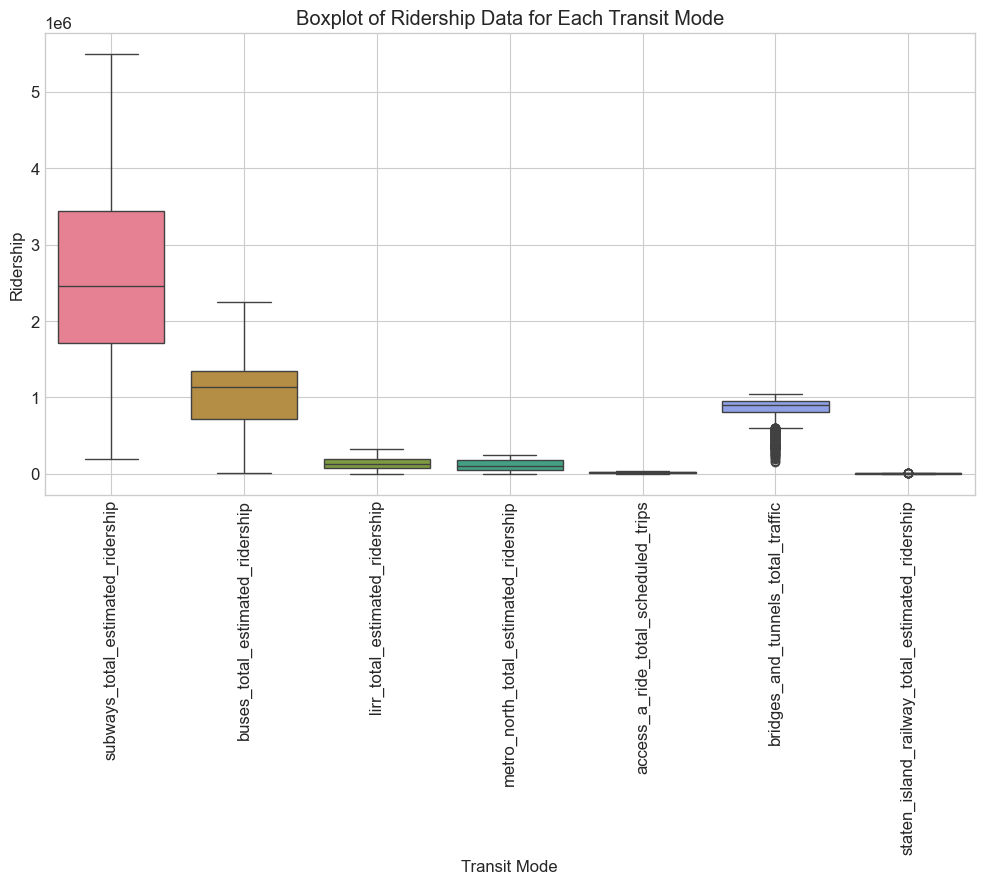

In [78]:
# Define the columns to visualize
columns = [
    'subways_total_estimated_ridership', 
    'buses_total_estimated_ridership',
    'lirr_total_estimated_ridership',
    'metro_north_total_estimated_ridership',
    'access_a_ride_total_scheduled_trips',
    'bridges_and_tunnels_total_traffic',
    'staten_island_railway_total_estimated_ridership'
]

# Set plot size
plt.figure(figsize=(12, 6))

# Create a boxplot
sns.boxplot(data=df[columns])
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.title("Boxplot of Ridership Data for Each Transit Mode")
plt.xlabel("Transit Mode")
plt.ylabel("Ridership")
plt.grid(True)

# Show the plot
plt.show()


 - Points outside the whiskers are outliers (unusually high or low values).

In [79]:
df["bridges_and_tunnels_total_traffic"].value_counts()

bridges_and_tunnels_total_traffic
916246    2
961969    2
962670    2
872566    1
929653    1
         ..
864413    1
904733    1
908024    1
914827    1
952775    1
Name: count, Length: 1703, dtype: int64

In [81]:
df['staten_island_railway_total_estimated_ridership'].min()

0

# Key Data Analysis Questions

## 1. Trends Over Time:
- How has daily ridership evolved from the onset of the pandemic through the recovery phase?
- Can you identify significant turning points or trends for each transit mode (subway, bus, LIRR, Metro-North, etc.)?
(Visualization ideas: Line charts with annotated key dates; interactive time-series dashboards.)



In [20]:
# Set the date as the index for easier time-series analysis
df.set_index('date', inplace=True)

In [21]:
df.columns

Index(['subways_total_estimated_ridership',
       'subways_percent_of_comparable_pre_pandemic_day',
       'buses_total_estimated_ridership',
       'buses_percent_of_comparable_pre_pandemic_day',
       'lirr_total_estimated_ridership',
       'lirr_percent_of_comparable_pre_pandemic_day',
       'metro_north_total_estimated_ridership',
       'metro_north_percent_of_comparable_pre_pandemic_day',
       'access_a_ride_total_scheduled_trips',
       'access_a_ride_percent_of_comparable_pre_pandemic_day',
       'bridges_and_tunnels_total_traffic',
       'bridges_and_tunnels_percent_of_comparable_pre_pandemic_day',
       'staten_island_railway_total_estimated_ridership',
       'staten_island_railway_percent_of_comparable_pre_pandemic_day', 'year',
       'quarter', 'month', 'day'],
      dtype='object')

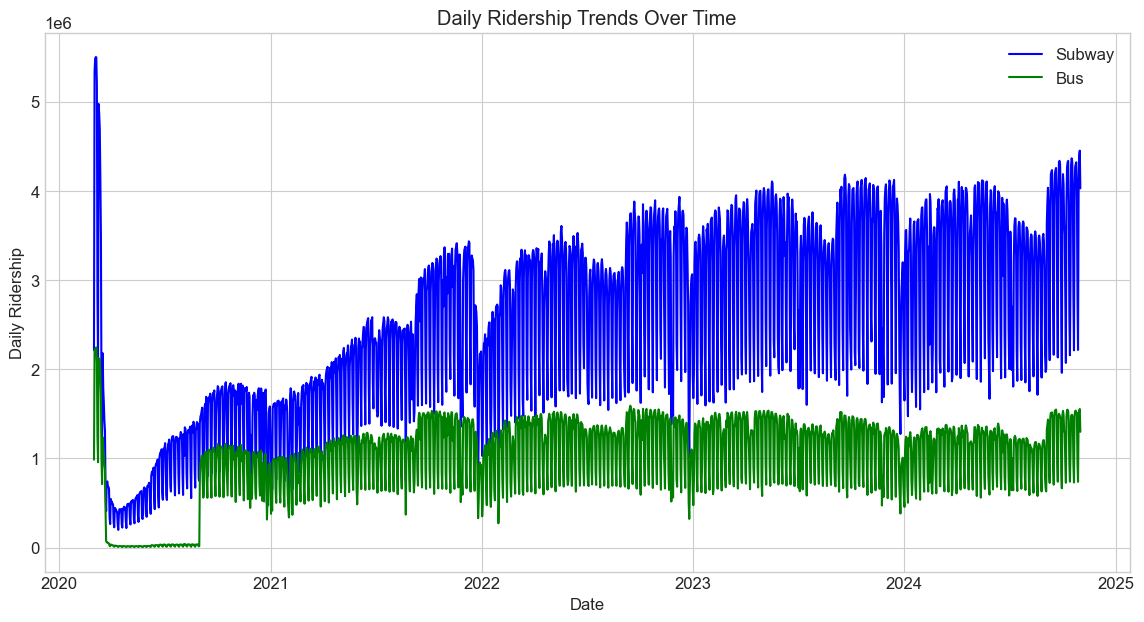

In [22]:
# Plot Trends Over Time for Each Transit Mode
plt.figure(figsize=(14, 7))

# Plot ridership trends for each transit mode
plt.plot(df.index, df['subways_total_estimated_ridership'], label="Subway", color='blue')
plt.plot(df.index, df['buses_total_estimated_ridership'], label="Bus", color='green')


# Add labels and title
plt.xlabel("Date")
plt.ylabel("Daily Ridership")
plt.title("Daily Ridership Trends Over Time")
plt.legend()
plt.grid(True)

# Show plot
plt.show()


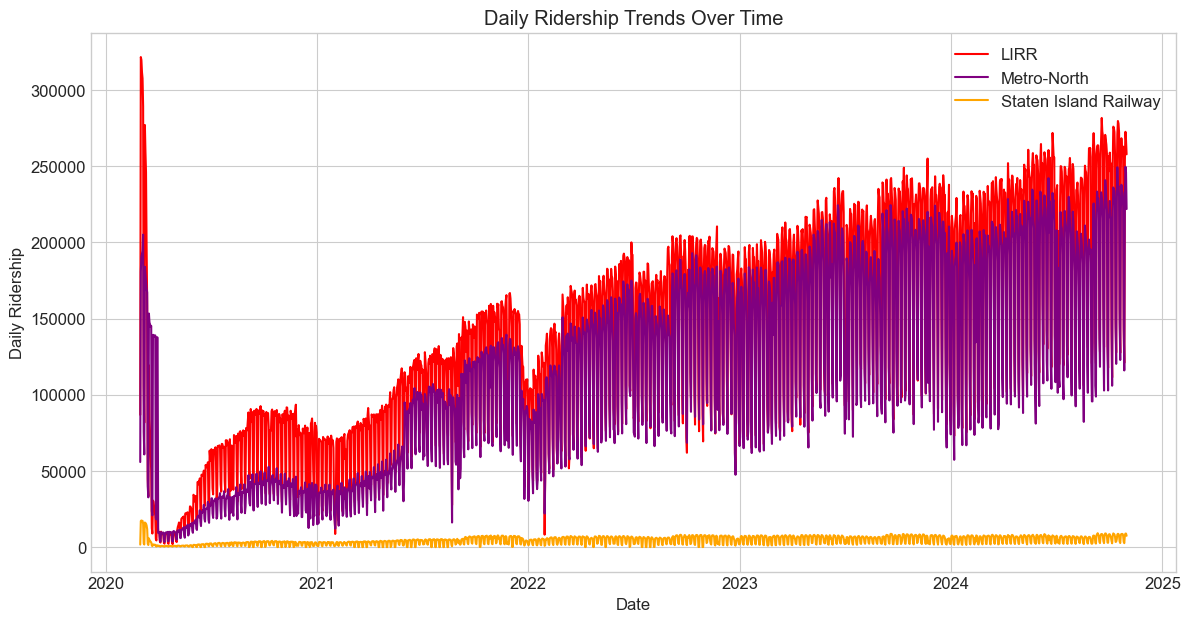

In [23]:
# Plot Trends Over Time for Each Transit Mode
plt.figure(figsize=(14, 7))

# Plot ridership trends for each transit mode
plt.plot(df.index, df['lirr_total_estimated_ridership'], label="LIRR", color='red')
plt.plot(df.index, df['metro_north_total_estimated_ridership'], label="Metro-North", color='purple')
plt.plot(df.index, df['staten_island_railway_total_estimated_ridership'], label="Staten Island Railway", color='orange')

# Add labels and title
plt.xlabel("Date")
plt.ylabel("Daily Ridership")
plt.title("Daily Ridership Trends Over Time")
plt.legend()
plt.grid(True)

# Show plot
plt.show()

- March 2020: A sharp decline in all transit modes due to lockdown measures.
- Mid-2021: Gradual recovery as restrictions eased.
- Late 2021 - Early 2022: Fluctuations due to new COVID-19 variants.

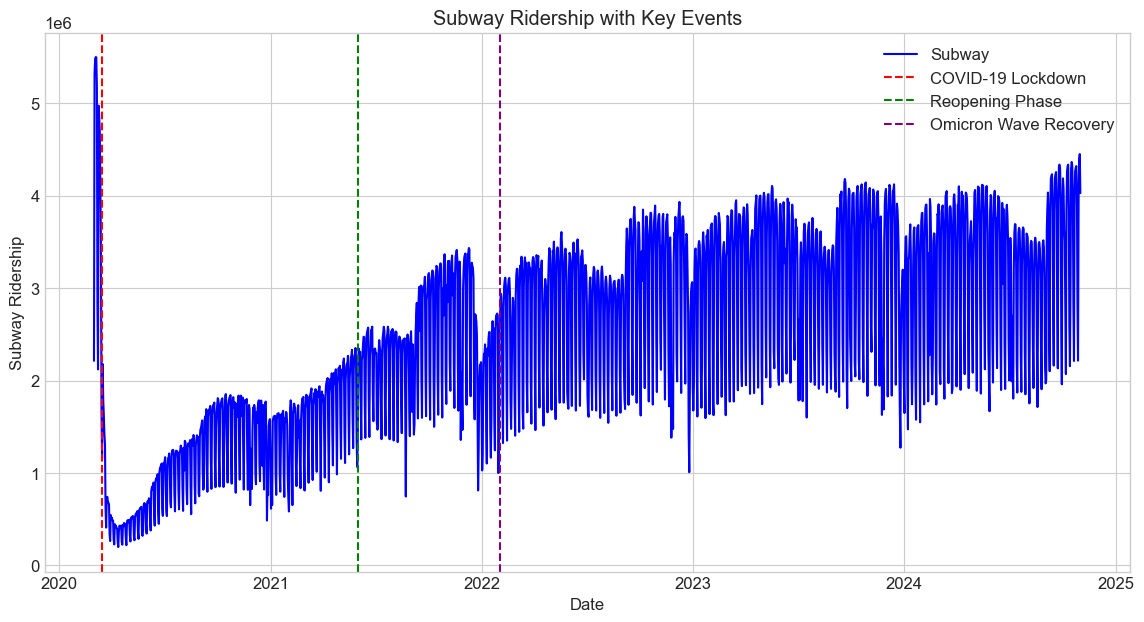

In [24]:
# To identify significant shifts in ridership (lockdowns, reopening phases and new variants)
plt.figure(figsize=(14, 7))

# Plot subway ridership with key turning points
plt.plot(df.index, df['subways_total_estimated_ridership'], label="Subway", color='blue')

# Annotate significant events
plt.axvline(pd.to_datetime("2020-03-15"), color='r', linestyle="--", label="COVID-19 Lockdown")
plt.axvline(pd.to_datetime("2021-06-01"), color='g', linestyle="--", label="Reopening Phase")
plt.axvline(pd.to_datetime("2022-02-01"), color='purple', linestyle="--", label="Omicron Wave Recovery")

# Add labels and title
plt.xlabel("Date")
plt.ylabel("Subway Ridership")
plt.title("Subway Ridership with Key Events")
plt.legend()
plt.grid(True)
# Y axis is in millions
# Show plot
plt.show()

In [25]:
# interactive line chart
fig = px.line(df, x=df.index, y=['subways_total_estimated_ridership', 
                                 'buses_total_estimated_ridership', 
                                 'lirr_total_estimated_ridership', 
                                 'metro_north_total_estimated_ridership'],
              labels={"value": "Daily Ridership", "variable": "Transit Mode"},
              title="Interactive Ridership Trends Over Time")

fig.show()

## 2. Pre-Pandemic Comparisons:
- How do current ridership numbers compare with the pre-pandemic baselines?
- What patterns emerge when comparing weekday, Saturday, and Sunday/holiday ridership?
(Visualization ideas: Bar charts or grouped box plots comparing percentage differences.)

In [26]:
# Reset index to have date as a column again if it's currently the index
if isinstance(df.index, pd.DatetimeIndex):
    df = df.reset_index()

# Extract day of the week
df['Day_of_Week'] = pd.to_datetime(df['date']).dt.day_name()

# Categorize days into Weekday and Holiday
df['Day_Type'] = df['Day_of_Week'].apply(lambda x: 'Weekday' if x in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'] 
                                          else 'Holiday')

In [27]:
df.head()

date  subways_total_estimated_ridership  \
0 2020-03-01                            2212965   
1 2020-03-02                            5329915   
2 2020-03-03                            5481103   
3 2020-03-04                            5498809   
4 2020-03-05                            5496453   

   subways_percent_of_comparable_pre_pandemic_day  \
0                                            97.0   
1                                            96.0   
2                                            98.0   
3                                            99.0   
4                                            99.0   

   buses_total_estimated_ridership  \
0                           984908   
1                          2209066   
2                          2228608   
3                          2177165   
4                          2244515   

   buses_percent_of_comparable_pre_pandemic_day  \
0                                          99.0   
1                                          99.0   
2                                          99.0   
3                                          97.0   
4                                         100.0   

   lirr_total_estimated_ridership  \
0                           86790   
1                          321569   
2                          319727   
3                          311662   
4                          307597   

   lirr_percent_of_comparable_pre_pandemic_day  \
0                                        100.0   
1                                        103.0   
2                                        102.0   
3                                         99.0   
4                                         98.0   

   metro_north_total_estimated_ridership  \
0                                  55825   
1                                 180701   
2                                 190648   
3                                 192689   
4                                 194386   

   metro_north_percent_of_comparable_pre_pandemic_day  \
0                                               59.0    
1                                               66.0    
2                                               69.0    
3                                               70.0    
4                                               70.0    

   access_a_ride_total_scheduled_trips  ...  \
0                                19922  ...   
1                                30338  ...   
2                                32767  ...   
3                                34297  ...   
4                                33209  ...   

   bridges_and_tunnels_total_traffic  \
0                             786960   
1                             874619   
2                             882175   
3                             905558   
4                             929298   

   bridges_and_tunnels_percent_of_comparable_pre_pandemic_day  \
0                                               98.0            
1                                               95.0            
2                                               96.0            
3                                               98.0            
4                                              101.0            

   staten_island_railway_total_estimated_ridership  \
0                                             1636   
1                                            17140   
2                                            17453   
3                                            17136   
4                                            17203   

   staten_island_railway_percent_of_comparable_pre_pandemic_day  year  \
0                                               52.0             2020   
1                                              107.0             2020   
2                                              109.0             2020   
3                                              107.0             2020   
4                                              108.0             2020   

   quarter  month  day  Day_of_Week

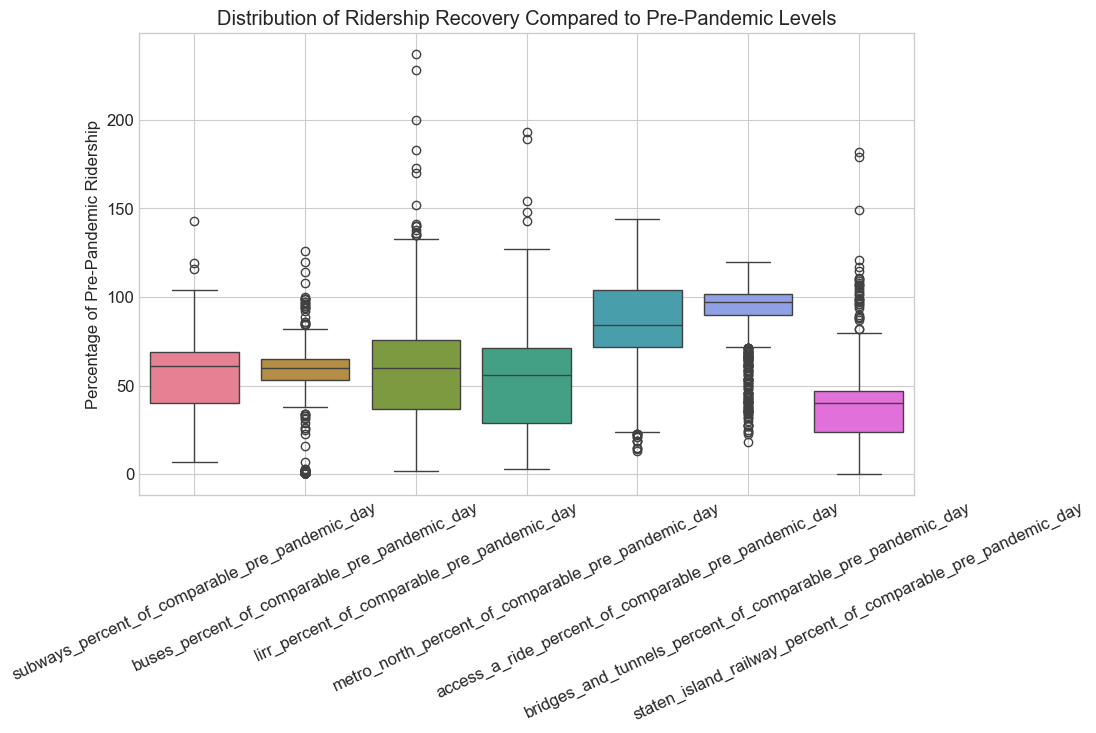

In [28]:
# Compare Current Ridership with Pre-Pandemic Levels
# Define relevant columns for comparison
modes = [
    'subways_percent_of_comparable_pre_pandemic_day',
    'buses_percent_of_comparable_pre_pandemic_day',
    'lirr_percent_of_comparable_pre_pandemic_day',
    'metro_north_percent_of_comparable_pre_pandemic_day',
    'access_a_ride_percent_of_comparable_pre_pandemic_day',
    'bridges_and_tunnels_percent_of_comparable_pre_pandemic_day',
    'staten_island_railway_percent_of_comparable_pre_pandemic_day'
]

# Plot boxplot to see distribution of percentage recovery for each mode
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[modes])
plt.title("Distribution of Ridership Recovery Compared to Pre-Pandemic Levels")
plt.ylabel("Percentage of Pre-Pandemic Ridership")
plt.xticks(rotation=25)
plt.grid(True)
plt.show()


- If the median is below 100%, ridership has not fully recovered.
- Some modes may have recovered better than others (e.g., buses vs. subways).

### _Analyze Ridership by Weekdays and Holidays_

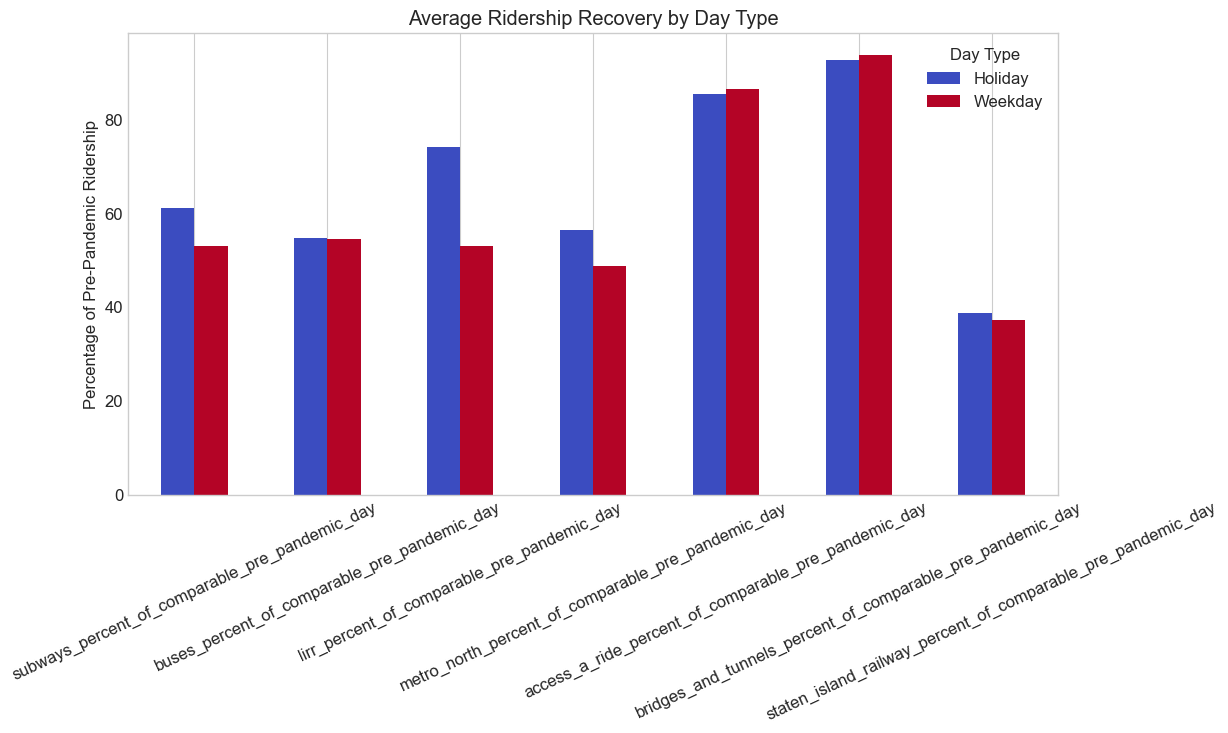

In [29]:
# Group by Day Type and calculate average ridership recovery
day_type_avg = df.groupby("Day_Type")[modes].mean()

# Plot bar chart
day_type_avg.T.plot(kind='bar', figsize=(12, 6), colormap="coolwarm")
plt.title("Average Ridership Recovery by Day Type")
plt.ylabel("Percentage of Pre-Pandemic Ridership")
plt.xticks(rotation=25)
plt.legend(title="Day Type")
plt.grid(axis="y")
plt.show()


- Weekday ridership might still be below 100% due to work-from-home trends.
- Weekend ridership may have recovered faster, especially for leisure-related transportation.
- Differences across transit modes highlight varying recovery trends.

### -Identify Trends for Individual Transit Modes (comparison)

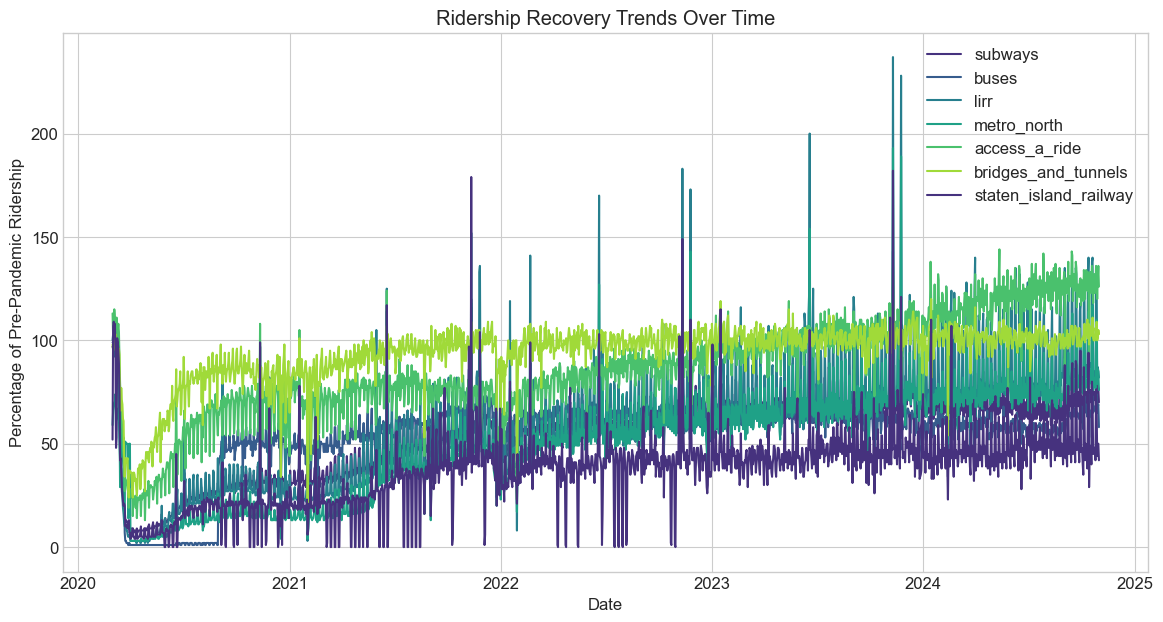

In [30]:
# Reset index to have date as a column again for plotting
df_plot = df.reset_index().copy()

# percent comparison pre- and post- Pandemic
plt.figure(figsize=(14, 7))

# Plot trends for different transit modes
for mode in modes:
    plt.plot(df_plot['date'], df_plot[mode], label=mode.replace('_percent_of_comparable_pre_pandemic_day', ''))

plt.xlabel("Date")
plt.ylabel("Percentage of Pre-Pandemic Ridership")
plt.title("Ridership Recovery Trends Over Time")
plt.legend()
plt.grid(True)
plt.show()


- Sharp declines in early 2020, slow recovery afterward.
- Some transit modes might fluctuate due to COVID-19 waves.
- Seasonal variations may affect specific modes (e.g., summer ridership increases).

## Day-of-Week and Seasonal Patterns:
- Are there consistent differences in ridership on weekdays versus weekends or holidays?
- What seasonal patterns (e.g., summer dips or winter spikes) can be observed across different transit systems?
(Visualization ideas: Heatmaps, calendar plots, or violin plots to display distribution across days.)

C:\Users\Asus\AppData\Local\Temp\ipykernel_376\2151139917.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




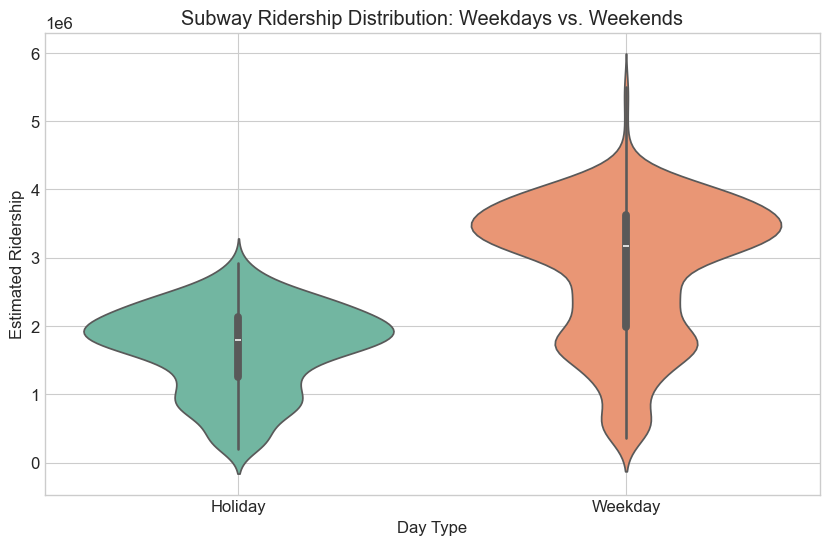

In [31]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='Day_Type', y='subways_total_estimated_ridership', data=df, palette='Set2')
plt.title("Subway Ridership Distribution: Weekdays vs. Weekends")
plt.ylabel("Estimated Ridership")
plt.xlabel("Day Type")
plt.grid(True)
plt.show()

C:\Users\Asus\AppData\Local\Temp\ipykernel_376\3312041060.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




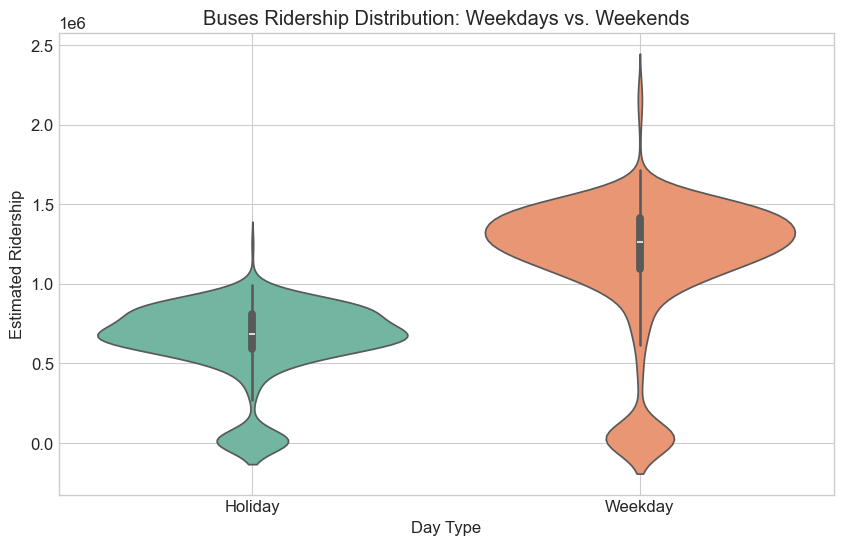

In [32]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='Day_Type', y='buses_total_estimated_ridership', data=df, palette='Set2')
plt.title("Buses Ridership Distribution: Weekdays vs. Weekends")
plt.ylabel("Estimated Ridership")
plt.xlabel("Day Type")
plt.grid(True)
plt.show()

C:\Users\Asus\AppData\Local\Temp\ipykernel_376\28716684.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




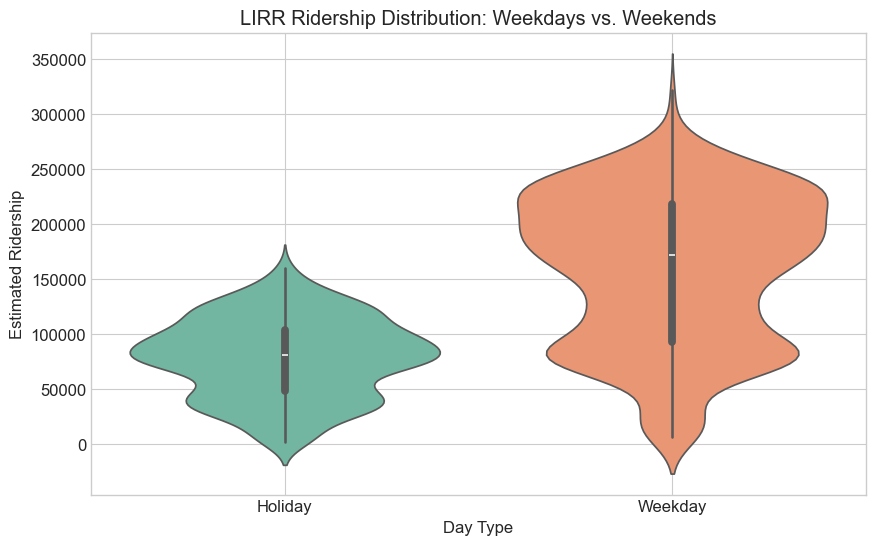

In [33]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='Day_Type', y='lirr_total_estimated_ridership', data=df, palette='Set2')
plt.title("LIRR Ridership Distribution: Weekdays vs. Weekends")
plt.ylabel("Estimated Ridership")
plt.xlabel("Day Type")
plt.grid(True)
plt.show()

C:\Users\Asus\AppData\Local\Temp\ipykernel_376\1829902327.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




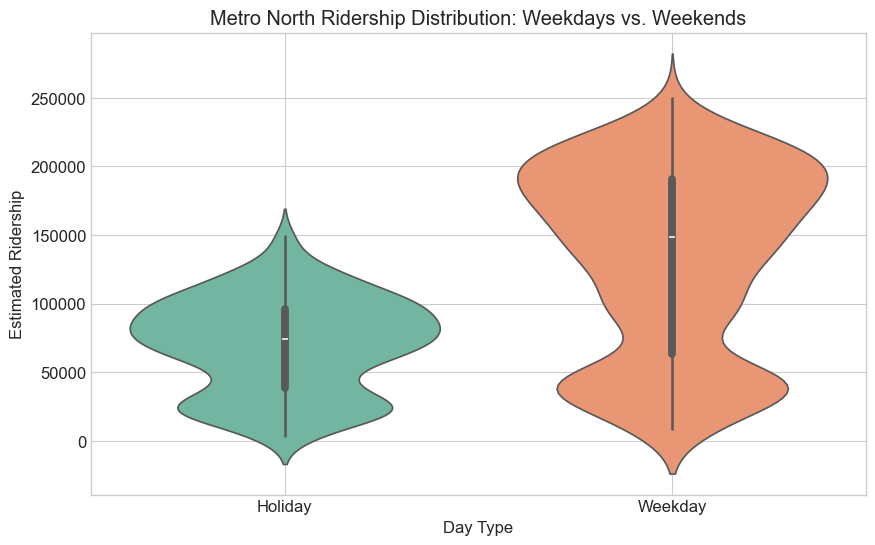

In [34]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='Day_Type', y='metro_north_total_estimated_ridership', data=df, palette='Set2')
plt.title("Metro North Ridership Distribution: Weekdays vs. Weekends")
plt.ylabel("Estimated Ridership")
plt.xlabel("Day Type")
plt.grid(True)
plt.show()

### Seasonal Pattern by Month and Day of Week

- This gives a birds-eye view of which months and weekdays are busiest.

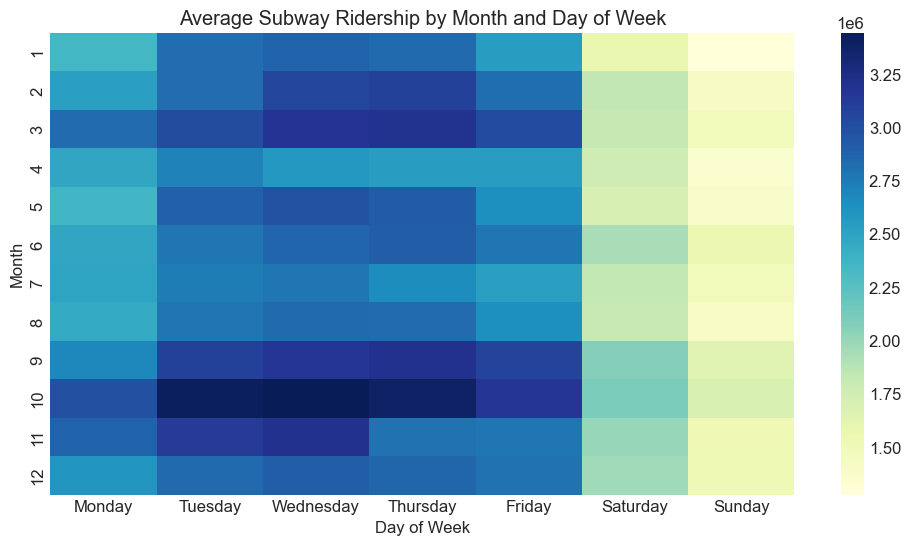

In [35]:
# Average subway ridership by day of week and month
pivot = df.pivot_table(values='subways_total_estimated_ridership', 
                       index='month', columns='Day_of_Week', aggfunc='mean')

# Reorder days for clarity
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot = pivot[ordered_days]

plt.figure(figsize=(12, 6))
# Fix: Using annot=False to avoid the conversion issue
sns.heatmap(pivot, annot=False, cmap='YlGnBu', fmt=".0f")
plt.title("Average Subway Ridership by Month and Day of Week")
plt.ylabel("Month")
plt.xlabel("Day of Week")
plt.show()

### **Monthly Trends Across Years

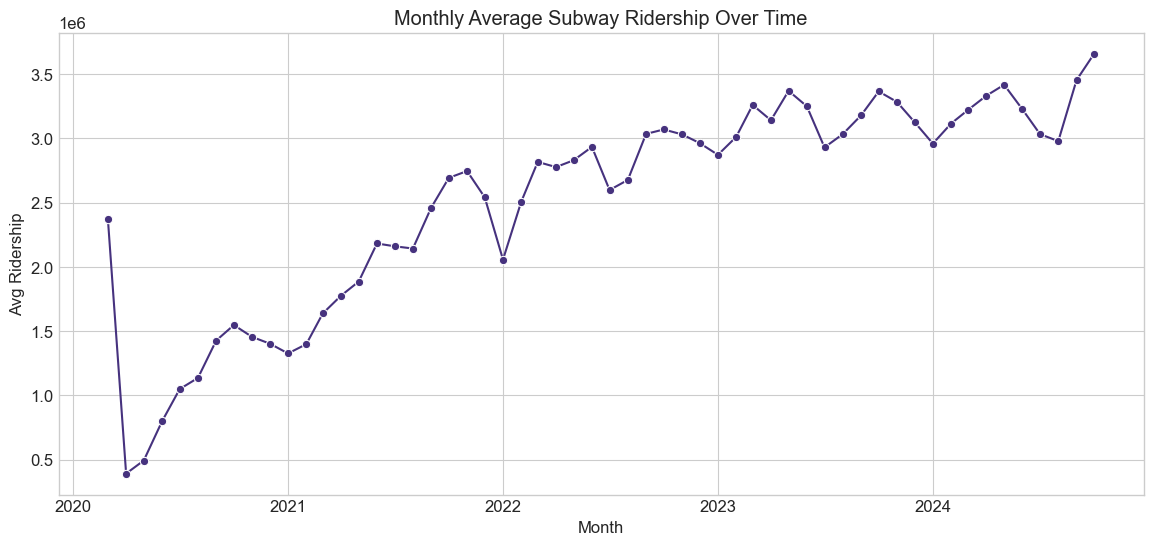

In [36]:
# Group by Year and Month to get monthly averages
monthly_trend = df.groupby(['year', 'month'])['subways_total_estimated_ridership'].mean().reset_index()

# Convert Year-Month to a datetime for plotting
monthly_trend['YearMonth'] = pd.to_datetime(monthly_trend['year'].astype(str) + '-' + monthly_trend['month'].astype(str))

plt.figure(figsize=(14, 6))
sns.lineplot(x='YearMonth', y='subways_total_estimated_ridership', data=monthly_trend, marker='o')
plt.title("Monthly Average Subway Ridership Over Time")
plt.ylabel("Avg Ridership")
plt.xlabel("Month")
plt.grid(True)
plt.show()

- Weekend dips in subway/bus ridership
- Summer drops (vacation season)
- Winter increases (fewer walking/biking alternatives)
- Post-pandemic shifts (e.g., more remote work = flatter weekday/weekend patterns).



## Anomaly and Outlier Detection:
- Which days or periods show unexpected ridership anomalies, and can these be linked to external events (e.g., weather, service disruptions, or special events)?
(Visualization ideas: Scatter plots with outlier detection, time series anomaly detection overlays.)

In [37]:
# Set Date as index
df.set_index('date', inplace=True)

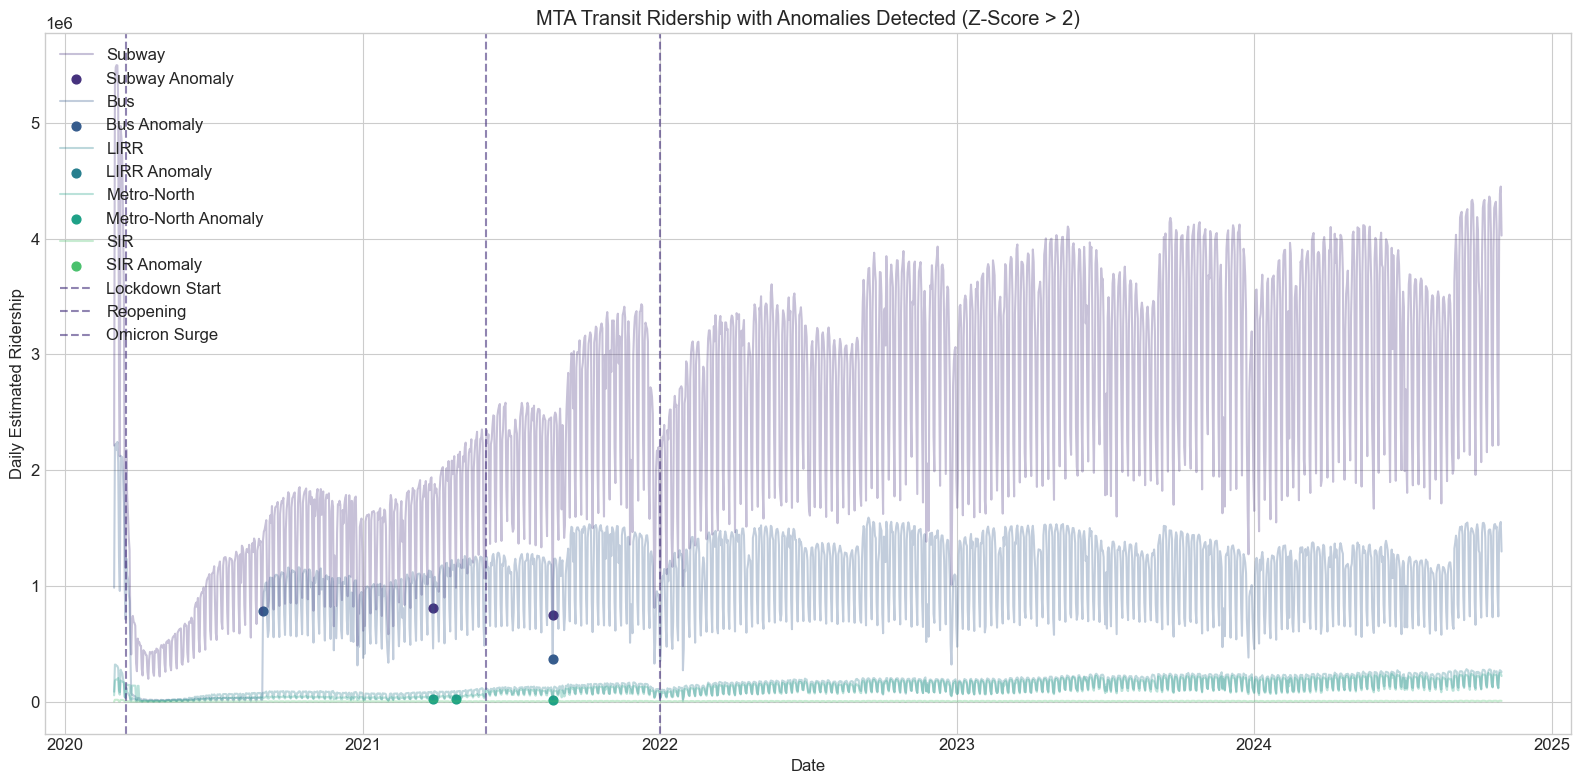

In [38]:
# Transit modes to analyze
modes = {
    'subways_total_estimated_ridership': 'Subway',
    'buses_total_estimated_ridership': 'Bus',
    'lirr_total_estimated_ridership': 'LIRR',
    'metro_north_total_estimated_ridership': 'Metro-North',
    'staten_island_railway_total_estimated_ridership': 'SIR',
}

# Create figure
plt.figure(figsize=(16, 8))

# Loop over each mode
for col, label in modes.items():
    # Rolling mean & std
    roll = df[col].rolling(window=7)
    mean = roll.mean()
    std = roll.std()
    z = (df[col] - mean) / std
    
    # Anomaly condition
    anomalies = z.abs() > 2

    # Plot main line
    plt.plot(df.index, df[col], label=label, alpha=0.3)
    
    # Plot anomalies as dots
    plt.scatter(df.index[anomalies], df[col][anomalies], label=f"{label} Anomaly", s=40, marker='o')
    
important_dates = {
    "Lockdown Start": "2020-03-15",
    "Reopening": "2021-06-01",
    "Omicron Surge": "2022-01-01"
}

for label, date in important_dates.items():
    plt.axvline(pd.to_datetime(date), linestyle="--", alpha=0.6, label=label)
# Formatting
plt.title("MTA Transit Ridership with Anomalies Detected (Z-Score > 2)")
plt.xlabel("Date")
plt.ylabel("Daily Estimated Ridership")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Correlation Between Modes:
- How are ridership trends across various transportation modes correlated?
- Do shifts in one mode (e.g., subway) correlate with compensatory changes in another (e.g., bus or commuter rail)?
(Visualization ideas: Correlation matrices, pair plots, or dual-axis line charts.)

In [39]:
# Focus on ridership columns
modes_cols = [
    'subways_total_estimated_ridership', 
    'buses_total_estimated_ridership',
    'lirr_total_estimated_ridership',
    'metro_north_total_estimated_ridership',
    'staten_island_railway_total_estimated_ridership',
    'access_a_ride_total_scheduled_trips',
    'bridges_and_tunnels_total_traffic'
]
modes_df = df[modes_cols]

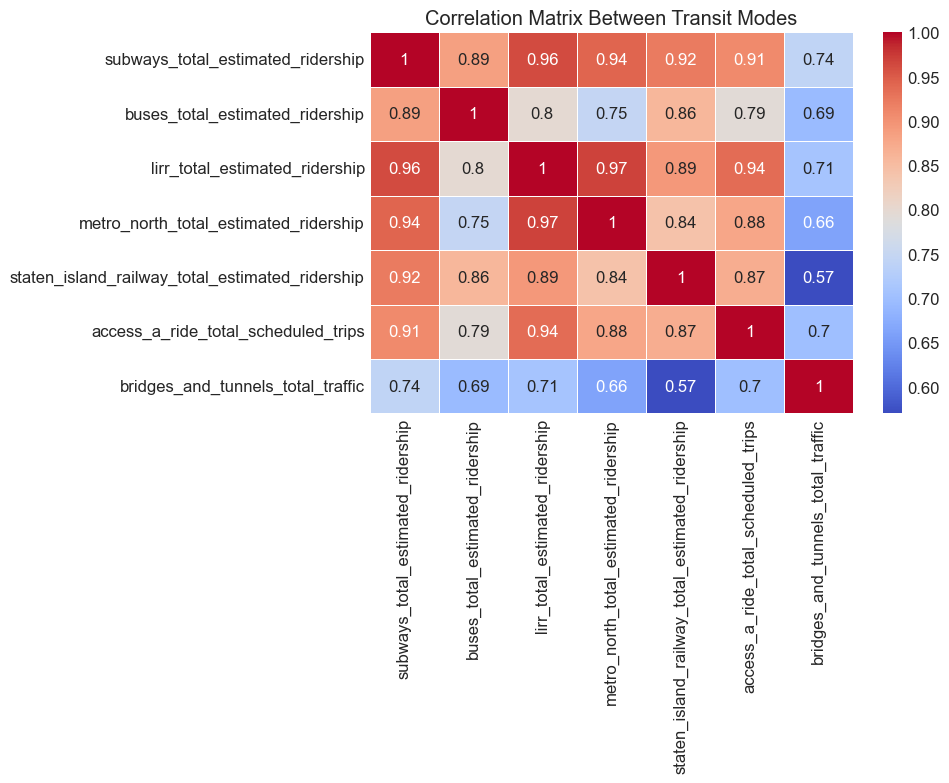

In [40]:
# Calculate correlation matrix
corr_matrix = modes_df.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix Between Transit Modes")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

- Strong correlation between subway and bus if people shift modes during service changes.
- LIRR and Metro-North might move together as both serve commuter populations.

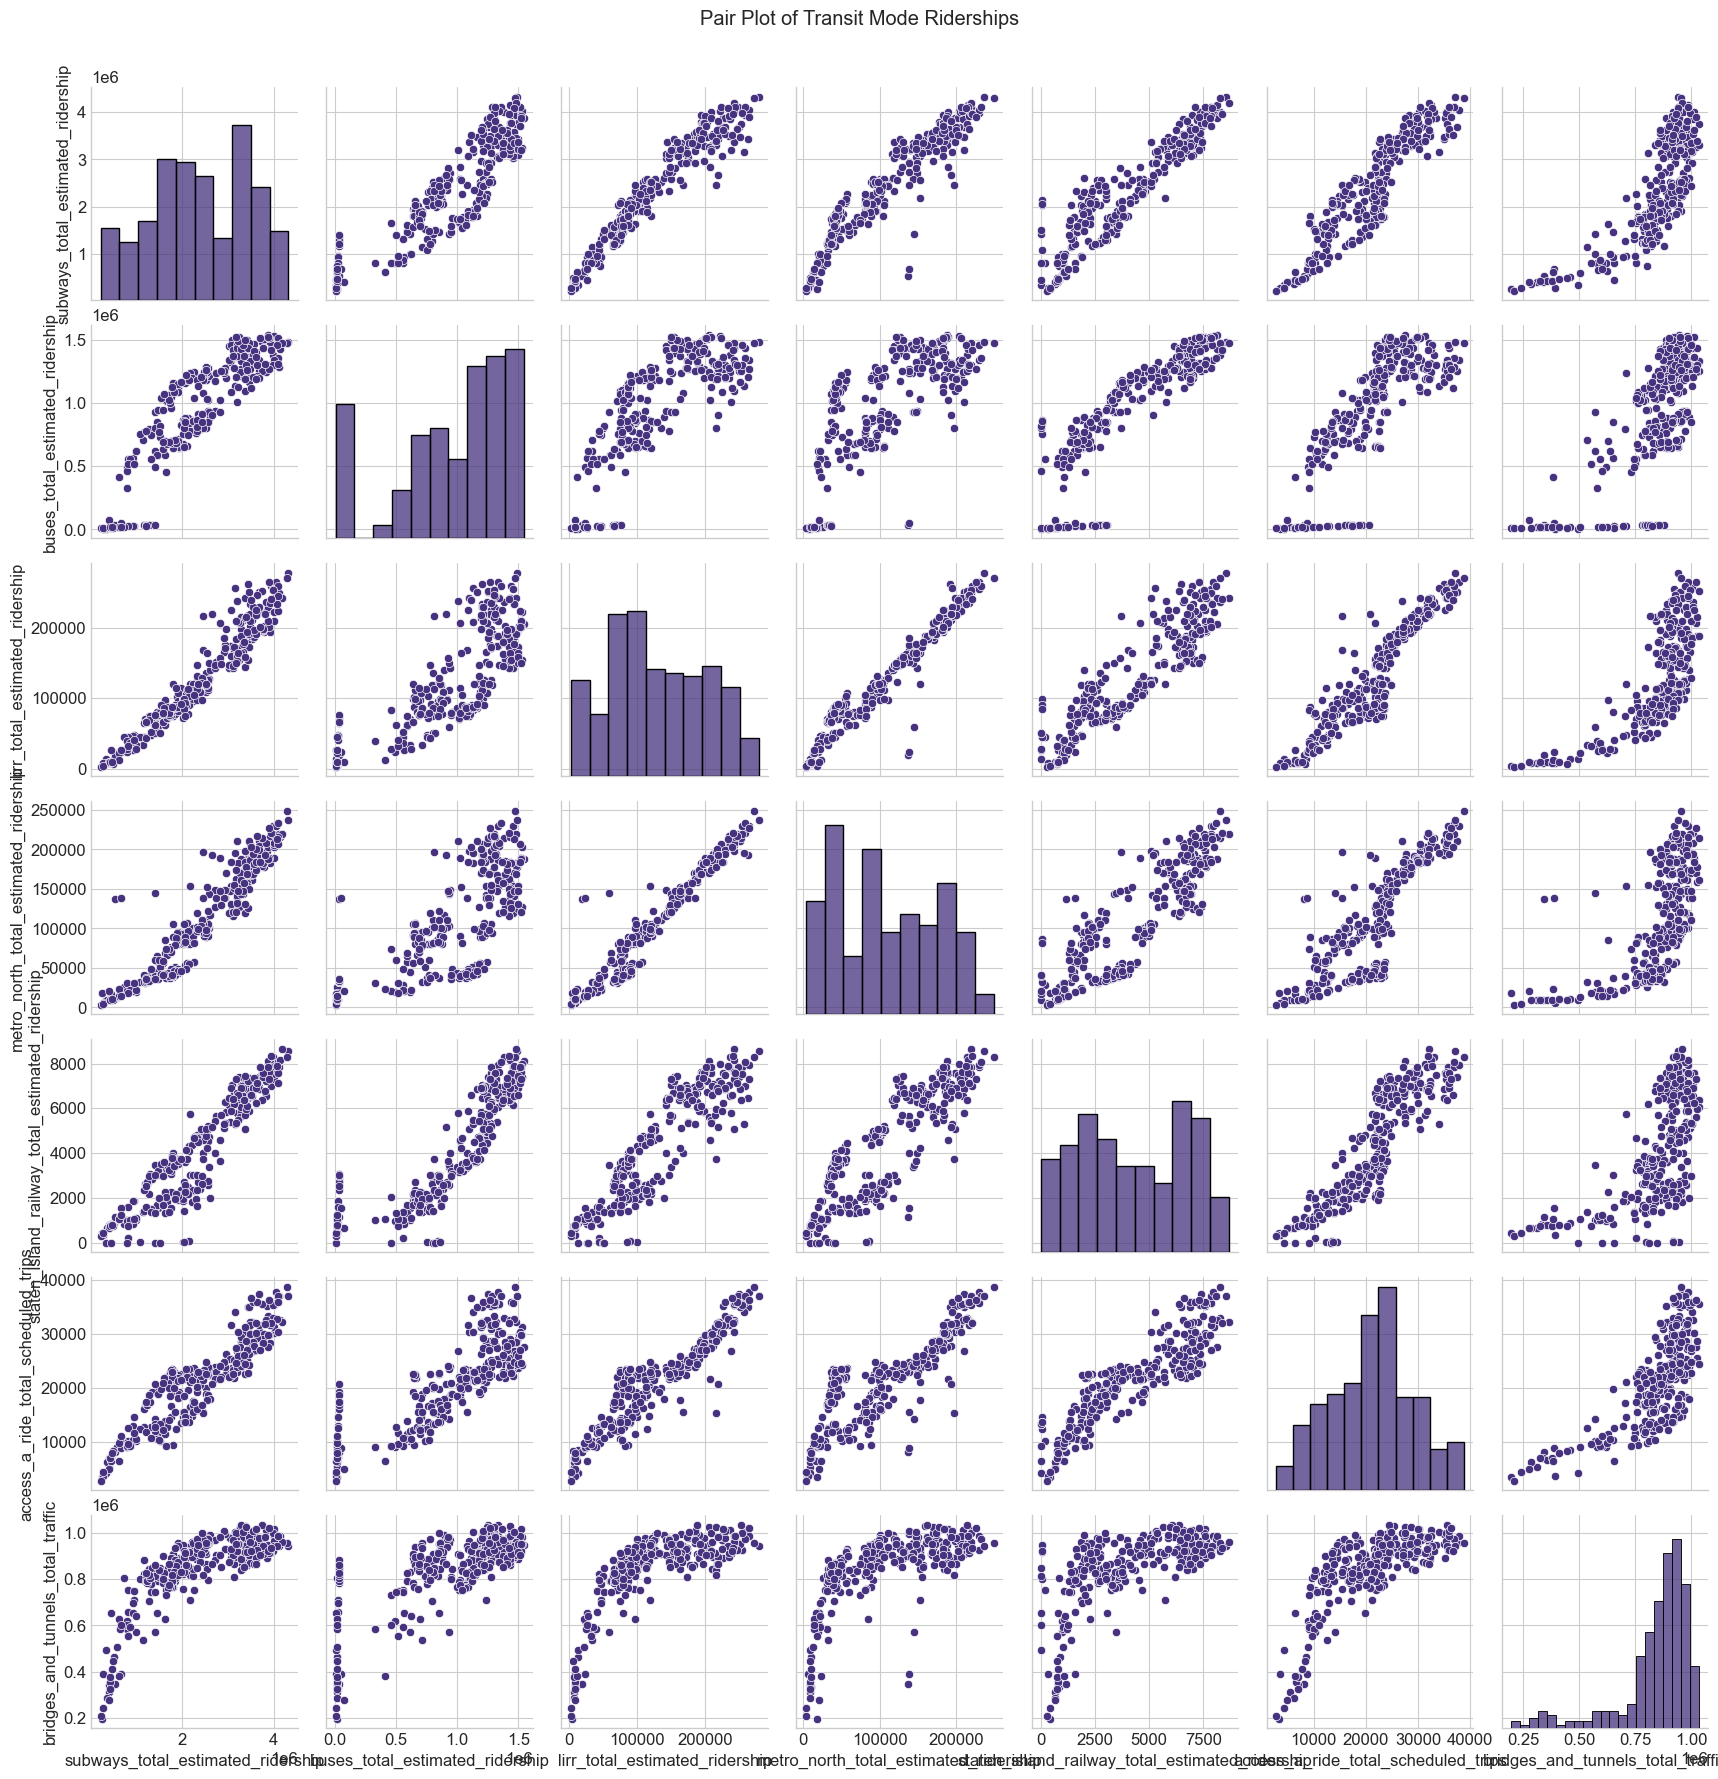

In [41]:
sns.pairplot(modes_df.sample(300))  # sample to reduce rendering time
plt.suptitle("Pair Plot of Transit Mode Riderships", y=1.02)
plt.xticks(rotation=90)
plt.show()

# Date Is not an index

## Impact of Methodological Changes:
- What impact did the February 2023 methodology upgrade (for calculating pre-COVID comparisons) have on the reported percentages?
- How do ridership comparisons before and after the change differ across transit systems?
(Visualization ideas: Comparative line charts or before-and-after visualizations with clear annotations.)

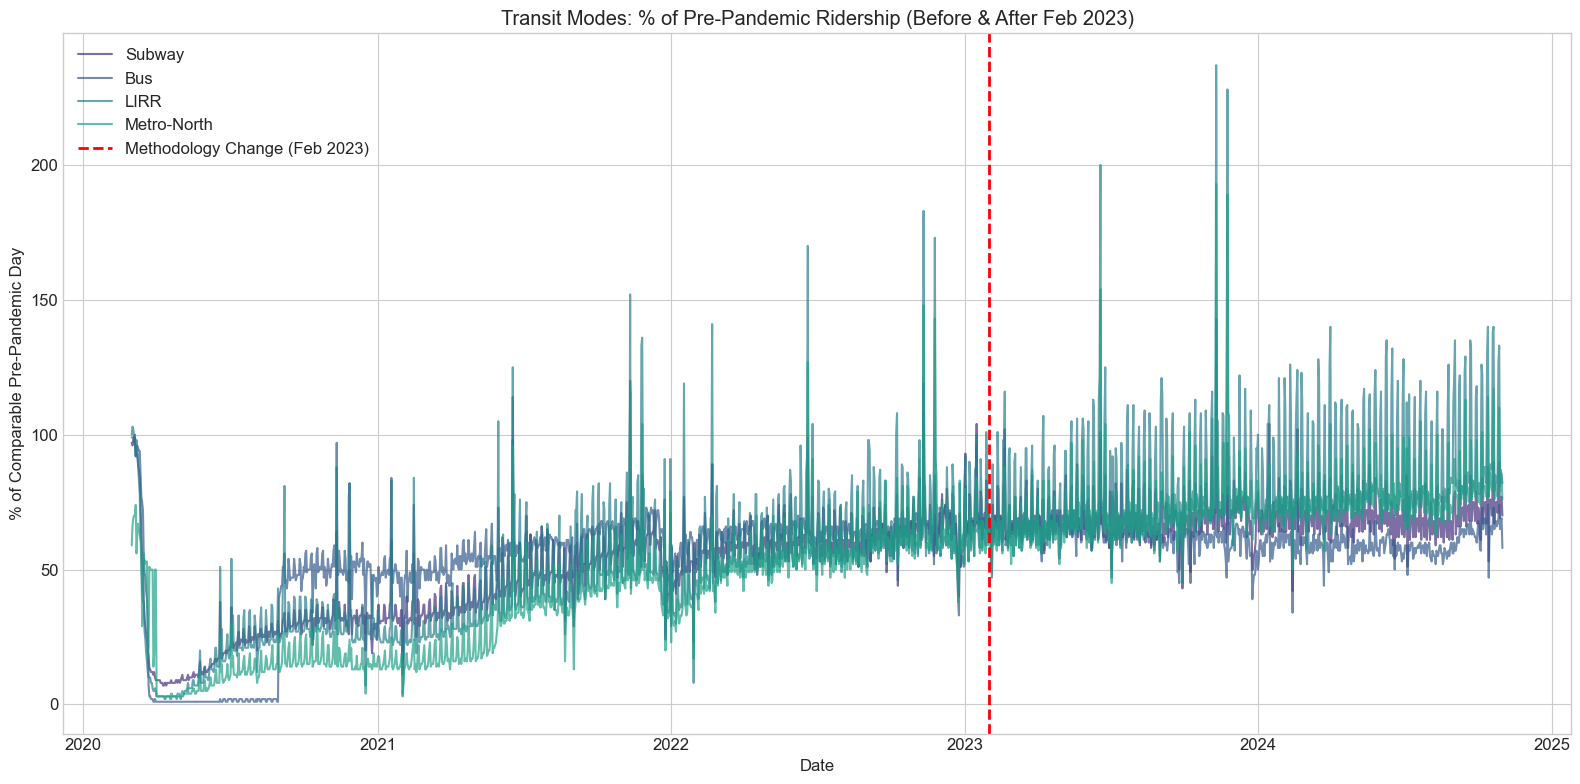

In [42]:
# Ensure date is available as a column
if isinstance(df.index, pd.DatetimeIndex):
    df = df.reset_index()

# List of columns and labels
mode_cols1 = {
    'subways_percent_of_comparable_pre_pandemic_day': 'Subway',
    'buses_percent_of_comparable_pre_pandemic_day': 'Bus',
    'lirr_percent_of_comparable_pre_pandemic_day': 'LIRR',
    'metro_north_percent_of_comparable_pre_pandemic_day': 'Metro-North'
}

# Plotting
plt.figure(figsize=(16, 8))

for col, label in mode_cols1.items():
    plt.plot(df['date'], df[col], label=label, alpha=0.7)

# Methodology change line
plt.axvline(pd.to_datetime("2023-02-01"), color='red', linestyle="--", linewidth=2, label="Methodology Change (Feb 2023)")

# Formatting
plt.title("Transit Modes: % of Pre-Pandemic Ridership (Before & After Feb 2023)")
plt.xlabel("Date")
plt.ylabel("% of Comparable Pre-Pandemic Day")
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

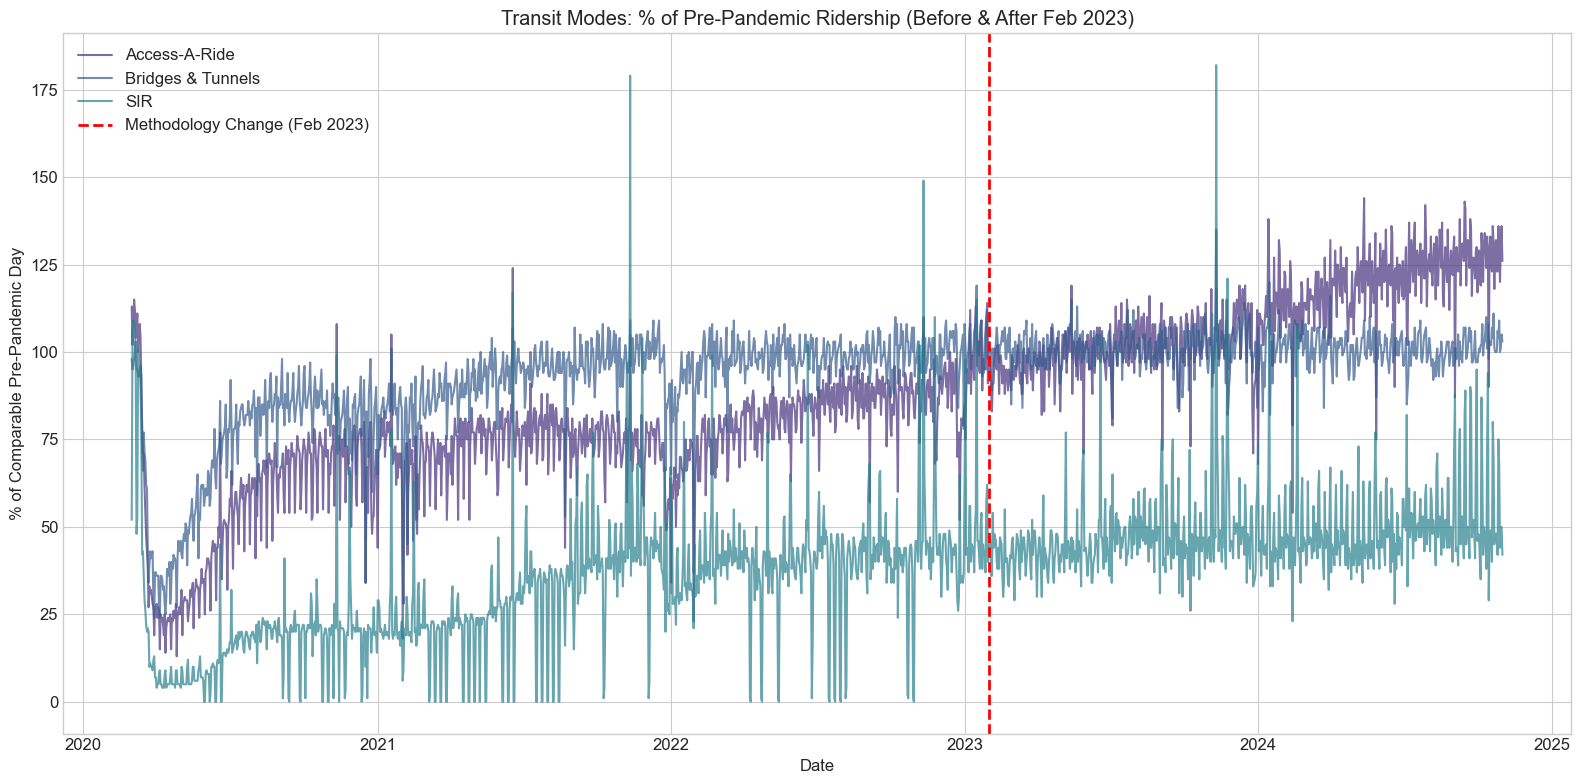

In [43]:
mode_cols2 = {
    'access_a_ride_percent_of_comparable_pre_pandemic_day': 'Access-A-Ride',
    'bridges_and_tunnels_percent_of_comparable_pre_pandemic_day': 'Bridges & Tunnels',
    'staten_island_railway_percent_of_comparable_pre_pandemic_day': 'SIR'
}
# Plotting
plt.figure(figsize=(16, 8))

for col, label in mode_cols2.items():
    plt.plot(df['date'], df[col], label=label, alpha=0.7)

# Methodology change line
plt.axvline(pd.to_datetime("2023-02-01"), color='red', linestyle="--", linewidth=2, label="Methodology Change (Feb 2023)")

# Formatting
plt.title("Transit Modes: % of Pre-Pandemic Ridership (Before & After Feb 2023)")
plt.xlabel("Date")
plt.ylabel("% of Comparable Pre-Pandemic Day")
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

- A red dashed vertical line shows the methodology change point.
- Some transit modes might show notable increases or decreases in their % after the methodology fix.

- Modes with lower baseline consistency (like Access-A-Ride) shows a larger jump. (blue line)

- Helps verify if comparison methods are now more accurate and uniform.



## Forecasting Future Ridership:
- Using historical data, what predictive models (like ARIMA, Prophet, or LSTM networks) best forecast future ridership trends?
- How accurate are these forecasts, and what potential factors could alter these predictions?
(Visualization ideas: Forecast plots with confidence intervals, residual analysis plots.)

In [44]:
# Newest date in our dataset
df['date'].max()

Timestamp('2024-10-31 00:00:00')

# Add line after 31/10/2024

### _showing expected ridership trends over the next 3 months_

Forecasting:   0%|          | 0/3 [00:00<?, ?it/s]

00:26:05 - cmdstanpy - INFO - Chain [1] start processing
00:26:06 - cmdstanpy - INFO - Chain [1] done processing
00:26:06 - cmdstanpy - INFO - Chain [1] start processing
00:26:07 - cmdstanpy - INFO - Chain [1] done processing
00:26:07 - cmdstanpy - INFO - Chain [1] start processing
00:26:08 - cmdstanpy - INFO - Chain [1] done processing
00:26:08 - cmdstanpy - INFO - Chain [1] start processing
00:26:09 - cmdstanpy - INFO - Chain [1] done processing
00:26:09 - cmdstanpy - INFO - Chain [1] start processing
00:26:10 - cmdstanpy - INFO - Chain [1] done processing
00:26:10 - cmdstanpy - INFO - Chain [1] start processing
00:26:10 - cmdstanpy - INFO - Chain [1] done processing


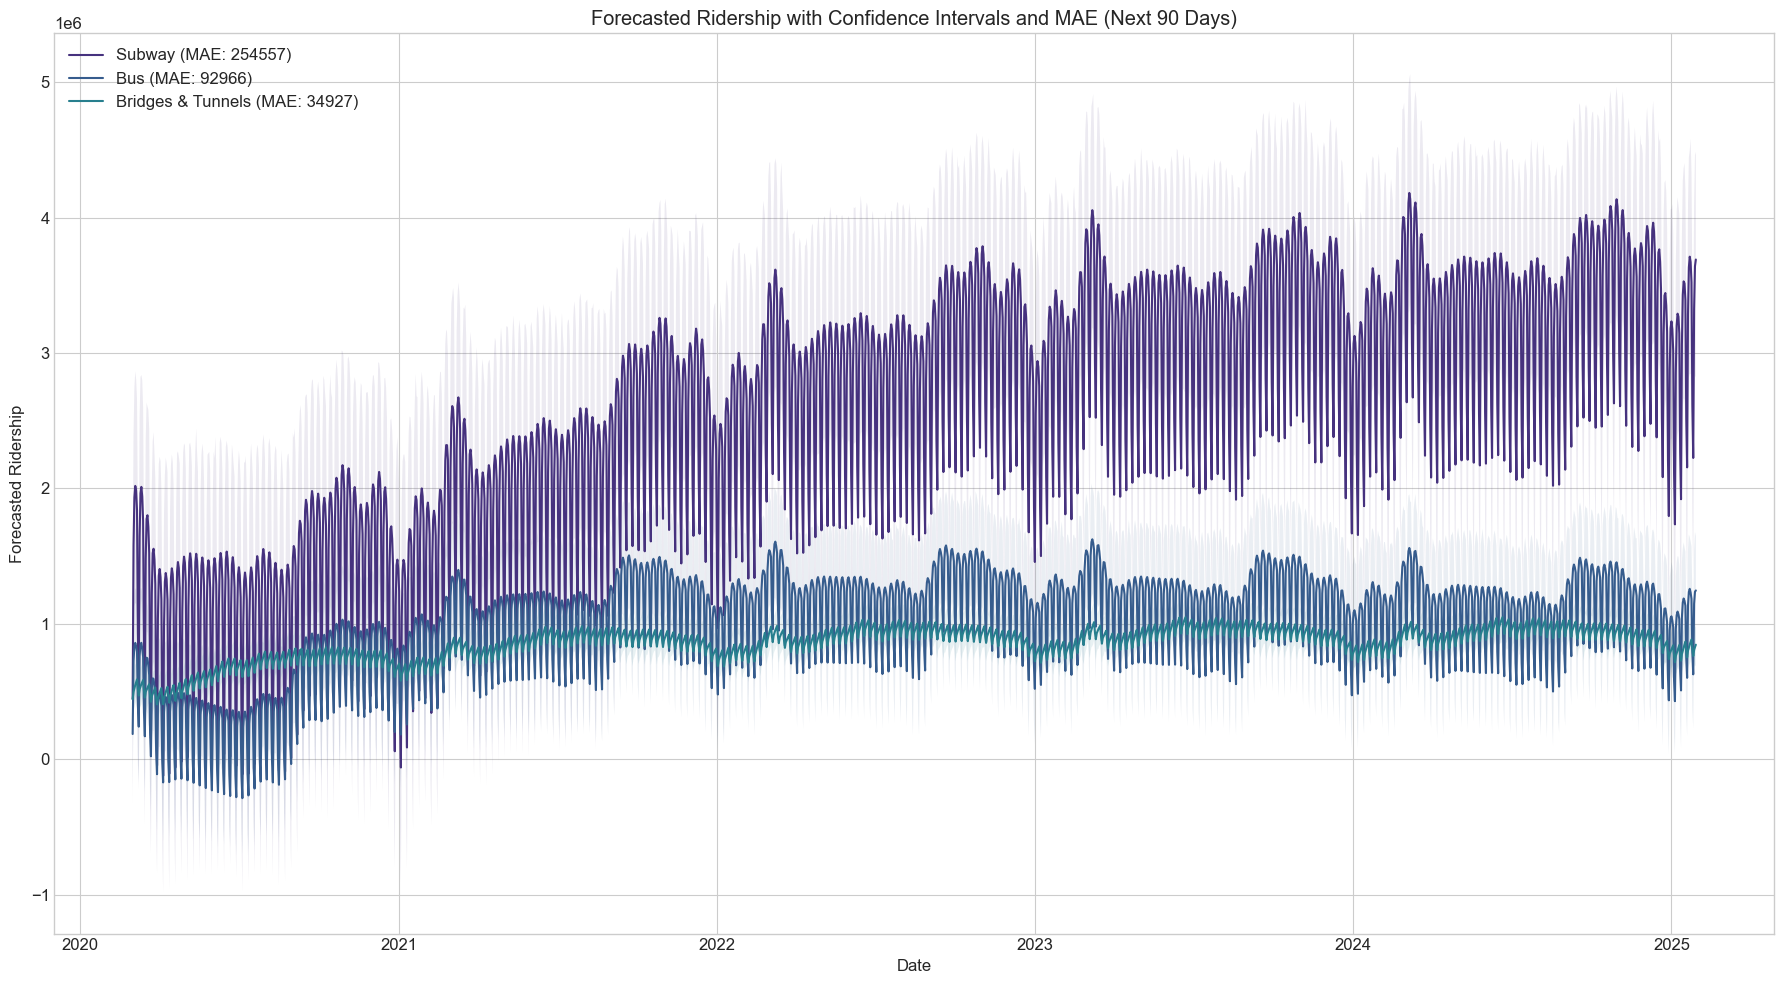


🔍 Mean Absolute Error (Last 90 Days Prediction Accuracy):
Subway: 254557.0
Bus: 92966.0
Bridges & Tunnels: 34927.0


In [45]:
# Transit modes to forecast
modes = {
    'subways_total_estimated_ridership': 'Subway',
    'buses_total_estimated_ridership': 'Bus',
    'bridges_and_tunnels_total_traffic': 'Bridges & Tunnels'
}

# Forecast horizon
forecast_horizon = 90  # days

# Store all forecasts in a dict
forecast_results = {}

# Stores MAE scores
mae_scores = {}

plt.figure(figsize=(18, 10))

# Use tqdm if available for a progress bar
try:
    from tqdm.notebook import tqdm
    mode_iterator = tqdm(modes.items(), desc="Forecasting")
except ImportError:
    mode_iterator = modes.items()
    print("Forecasting models...")

# Forecast loop with confidence intervals and backtesting
for i, (col, label) in enumerate(mode_iterator):
    # Prepare full data
    data = df[['date', col]].rename(columns={'date': 'ds', col: 'y'}).dropna()
    
    # --- Backtesting ---
    train = data[:-forecast_horizon]
    test = data[-forecast_horizon:].reset_index(drop=True)
    
    # Fit Prophet on training data with optimized parameters
    model = Prophet(
        daily_seasonality=True,
        yearly_seasonality=True,
        weekly_seasonality=True,
        seasonality_mode='additive',
        interval_width=0.95
    )
    model.fit(train)
    
    # Forecast same period as test
    future_bt = model.make_future_dataframe(periods=forecast_horizon)
    forecast_bt = model.predict(future_bt)
    
    # Get only predicted values matching test period
    forecast_bt_tail = forecast_bt.tail(forecast_horizon).reset_index(drop=True)
    
    # Calculate MAE
    mae = mean_absolute_error(test['y'], forecast_bt_tail['yhat'])
    mae_scores[label] = round(mae, 0)
    
    # --- Final Model for full data (for full future forecast + visualization) ---
    full_model = Prophet(
        daily_seasonality=True,
        yearly_seasonality=True,
        weekly_seasonality=True,
        seasonality_mode='additive',
        interval_width=0.95
    )
    full_model.fit(data)
    future = full_model.make_future_dataframe(periods=forecast_horizon)
    full_forecast = full_model.predict(future)
    
    forecast_results[label] = full_forecast
    
    # --- Plot with confidence intervals ---
    plt.plot(full_forecast['ds'], full_forecast['yhat'], label=f"{label} (MAE: {mae:.0f})")
    plt.fill_between(full_forecast['ds'], full_forecast['yhat_lower'], full_forecast['yhat_upper'], alpha=0.1)

# Final plot settings
plt.title("Forecasted Ridership with Confidence Intervals and MAE (Next 90 Days)")
plt.xlabel("Date")
plt.ylabel("Forecasted Ridership")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print MAE summary
print("\n🔍 Mean Absolute Error (Last 90 Days Prediction Accuracy):")
for label, score in mae_scores.items():
    print(f"{label}: {score}")

00:26:12 - cmdstanpy - INFO - Chain [1] start processing
00:26:12 - cmdstanpy - INFO - Chain [1] done processing
00:26:12 - cmdstanpy - INFO - Chain [1] start processing
00:26:13 - cmdstanpy - INFO - Chain [1] done processing
00:26:13 - cmdstanpy - INFO - Chain [1] start processing
00:26:14 - cmdstanpy - INFO - Chain [1] done processing
00:26:14 - cmdstanpy - INFO - Chain [1] start processing
00:26:14 - cmdstanpy - INFO - Chain [1] done processing
00:26:15 - cmdstanpy - INFO - Chain [1] start processing
00:26:15 - cmdstanpy - INFO - Chain [1] done processing
00:26:16 - cmdstanpy - INFO - Chain [1] start processing
00:26:16 - cmdstanpy - INFO - Chain [1] done processing
00:26:17 - cmdstanpy - INFO - Chain [1] start processing
00:26:17 - cmdstanpy - INFO - Chain [1] done processing
00:26:18 - cmdstanpy - INFO - Chain [1] start processing
00:26:18 - cmdstanpy - INFO - Chain [1] done processing


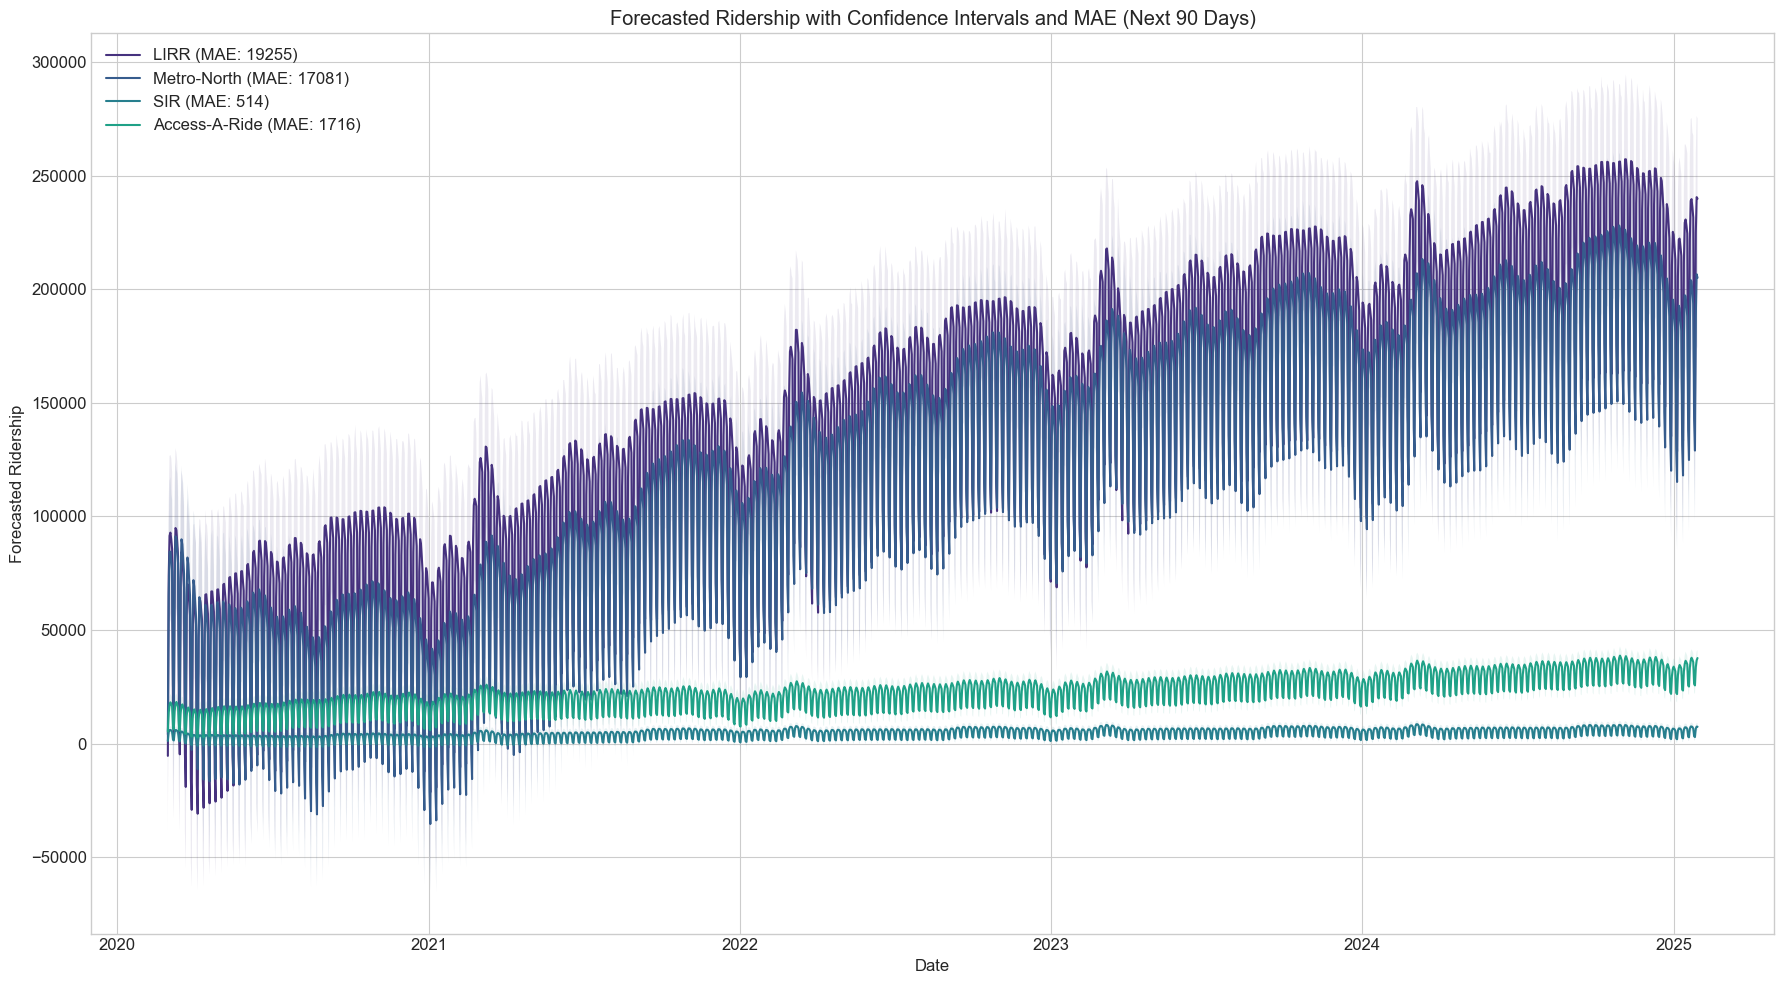


🔍 Mean Absolute Error (Last 90 Days Prediction Accuracy):
Subway: 254557.0
Bus: 92966.0
Bridges & Tunnels: 34927.0
LIRR: 19255.0
Metro-North: 17081.0
SIR: 514.0
Access-A-Ride: 1716.0


In [46]:
modes2 = {'lirr_total_estimated_ridership': 'LIRR',
    'metro_north_total_estimated_ridership': 'Metro-North',
    'staten_island_railway_total_estimated_ridership': 'SIR',
    'access_a_ride_total_scheduled_trips': 'Access-A-Ride'}
plt.figure(figsize=(18, 10))

# Forecast loop with confidence intervals and backtesting
for i, (col, label) in enumerate(modes2.items()):
    # Prepare full data
    data = df[['date', col]].rename(columns={'date': 'ds', col: 'y'}).dropna()
    
    # --- Backtesting ---
    train = data[:-forecast_horizon]
    test = data[-forecast_horizon:].reset_index(drop=True)

    # Fit Prophet on training data
    model = Prophet(daily_seasonality=True)
    model.fit(train)

    # Forecast same period as test
    future_bt = model.make_future_dataframe(periods=forecast_horizon)
    forecast_bt = model.predict(future_bt)

    # Get only predicted values matching test period
    forecast_bt_tail = forecast_bt.tail(forecast_horizon).reset_index(drop=True)
    
    # Calculate MAE
    mae = mean_absolute_error(test['y'], forecast_bt_tail['yhat'])
    mae_scores[label] = round(mae, 0)

    # --- Final Model for full data (for full future forecast + visualization) ---
    full_model = Prophet(daily_seasonality=True)
    full_model.fit(data)
    future = full_model.make_future_dataframe(periods=forecast_horizon)
    full_forecast = full_model.predict(future)

    forecast_results[label] = full_forecast

    # --- Plot with confidence intervals ---
    plt.plot(full_forecast['ds'], full_forecast['yhat'], label=f"{label} (MAE: {mae:.0f})")
    plt.fill_between(full_forecast['ds'], full_forecast['yhat_lower'], full_forecast['yhat_upper'], alpha=0.1)

# Final plot settings
plt.title("Forecasted Ridership with Confidence Intervals and MAE (Next 90 Days)")
plt.xlabel("Date")
plt.ylabel("Forecasted Ridership")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#Print MAE summary
print("\n🔍 Mean Absolute Error (Last 90 Days Prediction Accuracy):")
for label, score in mae_scores.items():
    print(f"{label}: {score}")

- Smooth lines showing expected ridership trends over the next 3 months.
- Shaded confidence bands (Prophet’s yhat_lower & yhat_upper).

- MAE displayed in the legend and printed below, showing how close predictions are to reality.

## Distribution and Variability Analysis:
- How does the distribution of daily ridership vary across the different MTA systems?
- Which systems show the highest variability, and what might explain these differences?
(Visualization ideas: Box plots, histograms, or density plots for each transit mode.)

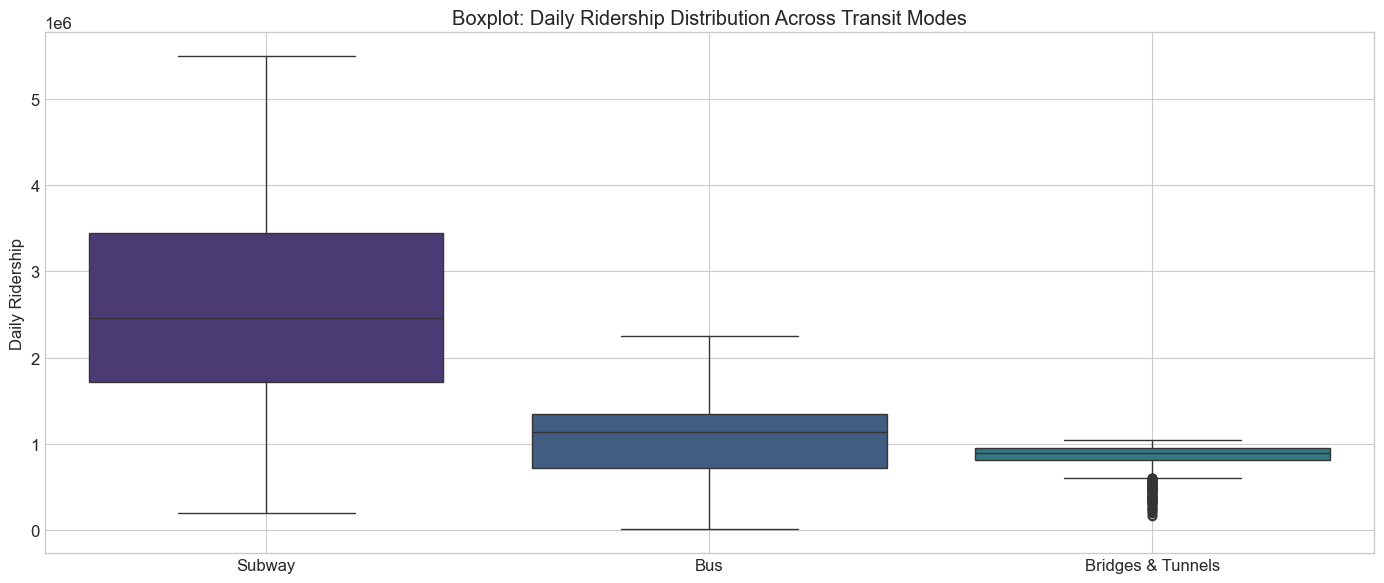

In [47]:
modes1 = {
     'subways_total_estimated_ridership': 'Subway',
    'buses_total_estimated_ridership': 'Bus',
    'bridges_and_tunnels_total_traffic': 'Bridges & Tunnels',
    
}

plt.figure(figsize=(14, 6))
sns.boxplot(data=df[list(modes1.keys())])
plt.title("Boxplot: Daily Ridership Distribution Across Transit Modes")
plt.xticks(ticks=range(len(modes1)), labels=modes1.values(), rotation=0)
plt.ylabel("Daily Ridership")
plt.grid(True)
plt.tight_layout()
plt.show()

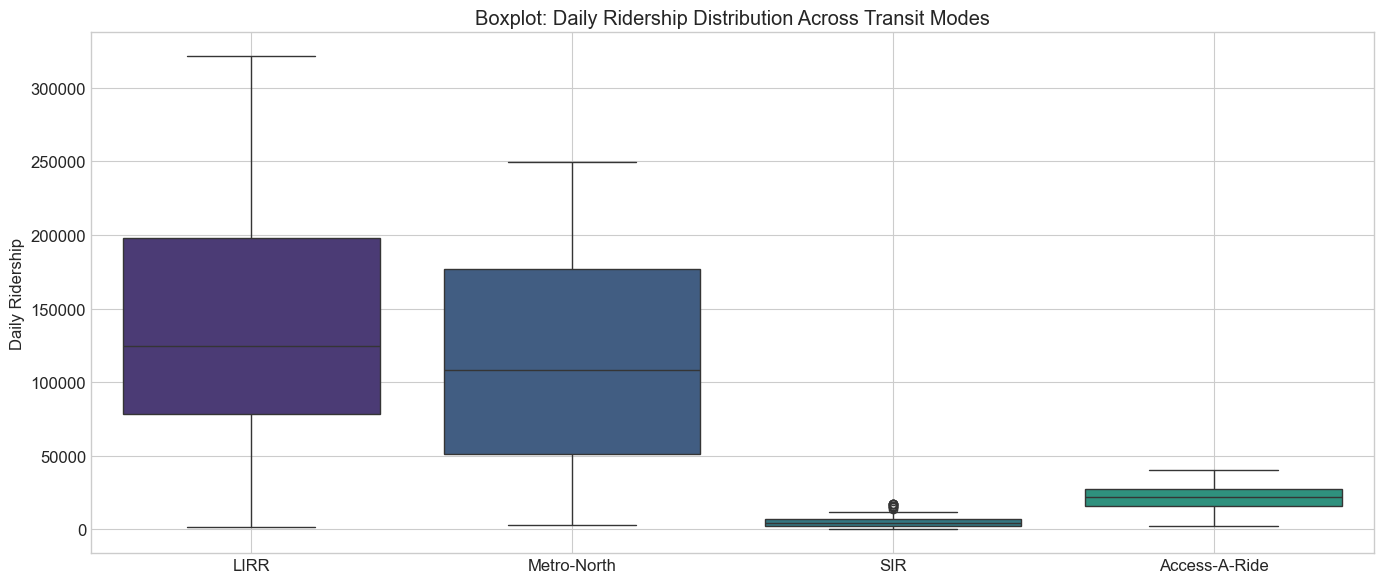

In [48]:
modes2={'lirr_total_estimated_ridership': 'LIRR',
    'metro_north_total_estimated_ridership': 'Metro-North',
    'staten_island_railway_total_estimated_ridership': 'SIR',
    'access_a_ride_total_scheduled_trips': 'Access-A-Ride'}
plt.figure(figsize=(14, 6))
sns.boxplot(data=df[list(modes2.keys())])
plt.title("Boxplot: Daily Ridership Distribution Across Transit Modes")
plt.xticks(ticks=range(len(modes2)), labels=modes2.values(), rotation=0)
plt.ylabel("Daily Ridership")
plt.grid(True)
plt.tight_layout()
plt.show()

- High variability = wider box / more outliers.

## Density Plot: Distribution of Daily Ridership by Mode

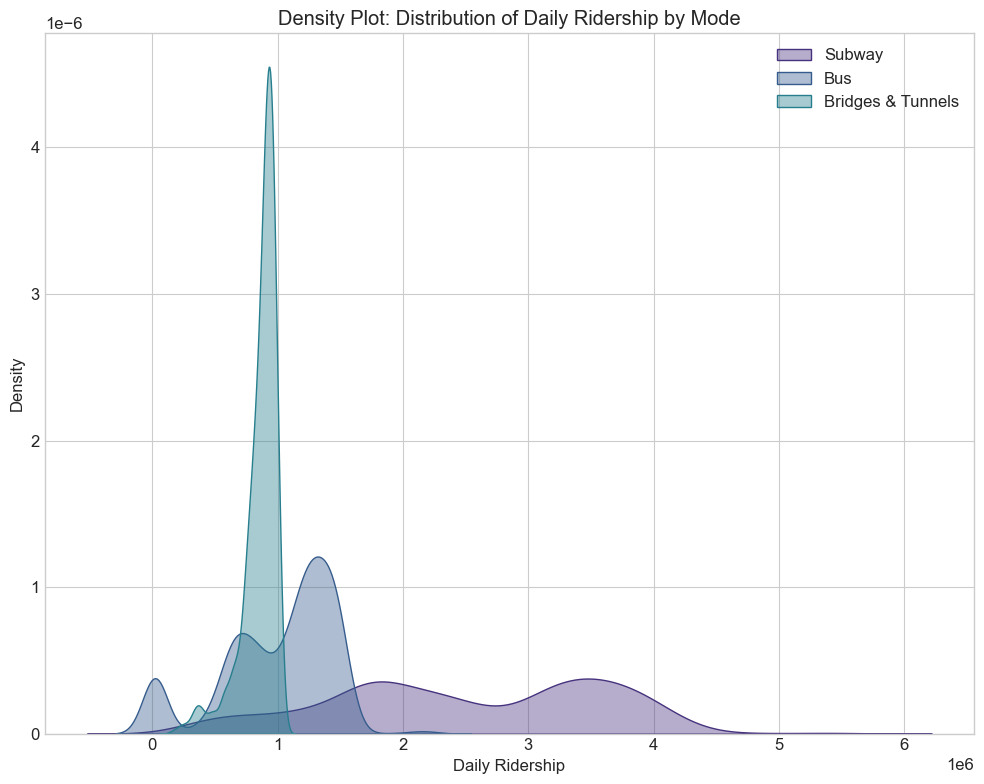

In [49]:
plt.figure(figsize=(10, 8))
for col, label in modes1.items():
    sns.kdeplot(df[col], label=label, fill=True, alpha=0.4)

plt.title("Density Plot: Distribution of Daily Ridership by Mode")
plt.xlabel("Daily Ridership")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

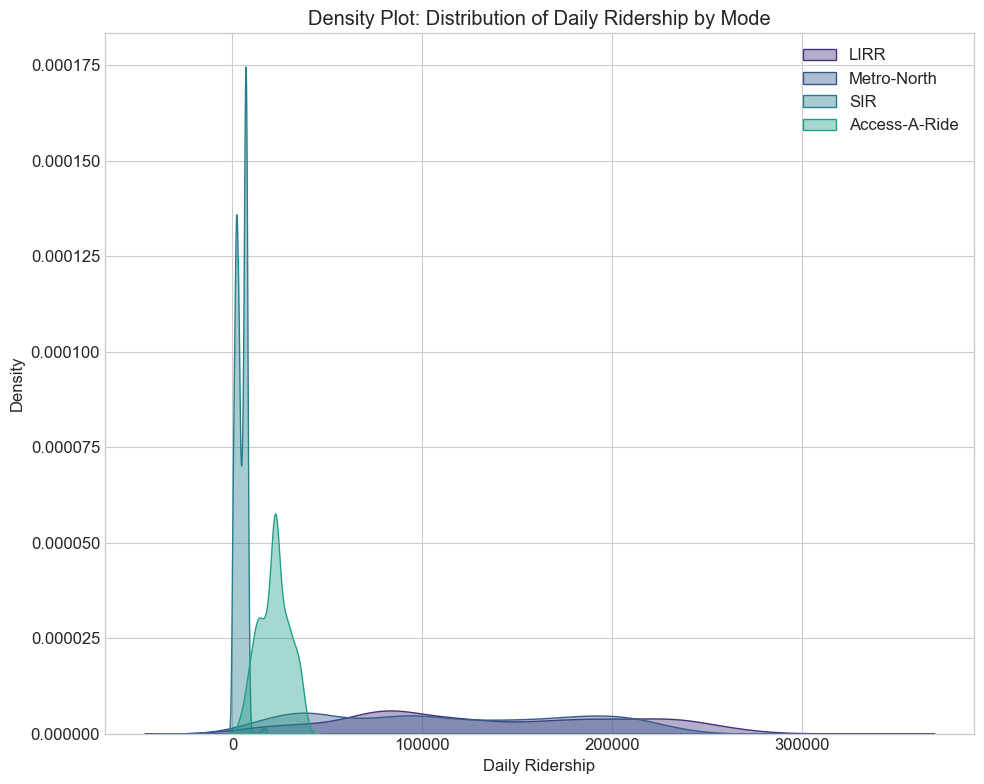

In [50]:
plt.figure(figsize=(10, 8))
for col, label in modes2.items():
    sns.kdeplot(df[col], label=label, fill=True, alpha=0.4)

plt.title("Density Plot: Distribution of Daily Ridership by Mode")
plt.xlabel("Daily Ridership")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Statistics

In [51]:
# Define modes dictionary if not already defined
if 'modes' not in locals():
    modes = {
        'subways_total_estimated_ridership': 'Subway',
        'buses_total_estimated_ridership': 'Bus',
        'lirr_total_estimated_ridership': 'LIRR',
        'metro_north_total_estimated_ridership': 'Metro-North',
        'staten_island_railway_total_estimated_ridership': 'SIR',
        'access_a_ride_total_scheduled_trips': 'Access-A-Ride',
        'bridges_and_tunnels_total_traffic': 'Bridges & Tunnels'
    }

# Calculate statistics
stats = pd.DataFrame({
    'Mean': df[list(modes.keys())].mean(),
    'Std Dev': df[list(modes.keys())].std(),
    'IQR': df[list(modes.keys())].quantile(0.75) - df[list(modes.keys())].quantile(0.25)
})

stats.index = [modes[col] for col in stats.index]
print("📈 Variability Summary:\n")
print(stats.sort_values(by='Std Dev', ascending=False).round(0))


📈 Variability Summary:

                        Mean    Std Dev        IQR
Subway             2509055.0  1062184.0  1724657.0
Bus                1006868.0   440380.0   632370.0
Bridges & Tunnels   855603.0   143184.0   136992.0


- System and	Possible Reasons:
  - *Subway*: Highest variability — big swings likely due to events (COVID-19, holidays, work-from-home shifts).
  - *Bus*: Moderate-high variation; possibly steadier than subway due to broader accessibility.
  - *LIRR / Metro-North*:	High relative variance — strong weekday usage but low on weekends.
  - *Access-A-Ride*: Very consistent — limited to eligible riders, less reactive to public events.
  - *Bridges & Tunnels*: Stable traffic patterns — more consistent than public transit.
  - *Staten Island Railway*: Very localized usage = less fluctuation, but small rider base makes it sensitive to minor changes.

Highest Variability: Subways
- Its Std Dev and IQR are significantly higher than any other system.

- This makes sense, as it's the core transit backbone in NYC — and most impacted by external factors (shutdowns, holidays, weather, strikes, remote work).

Most Stable:  Access-A-Ride and Bridges & Tunnels
- Access-A-Ride serves a fixed community.

- Bridges & Tunnels show low variation — possibly due to more predictable commuting patterns by car.



## Mode-Specific Recovery Patterns:
- How do recovery trajectories differ between transit modes, such as commuter rail (LIRR, Metro-North) versus urban transit (subway, bus)?
- What underlying factors could explain these variations?
(Visualization ideas: Multi-line time-series charts or segmented bar graphs that compare recovery trends across different systems.)

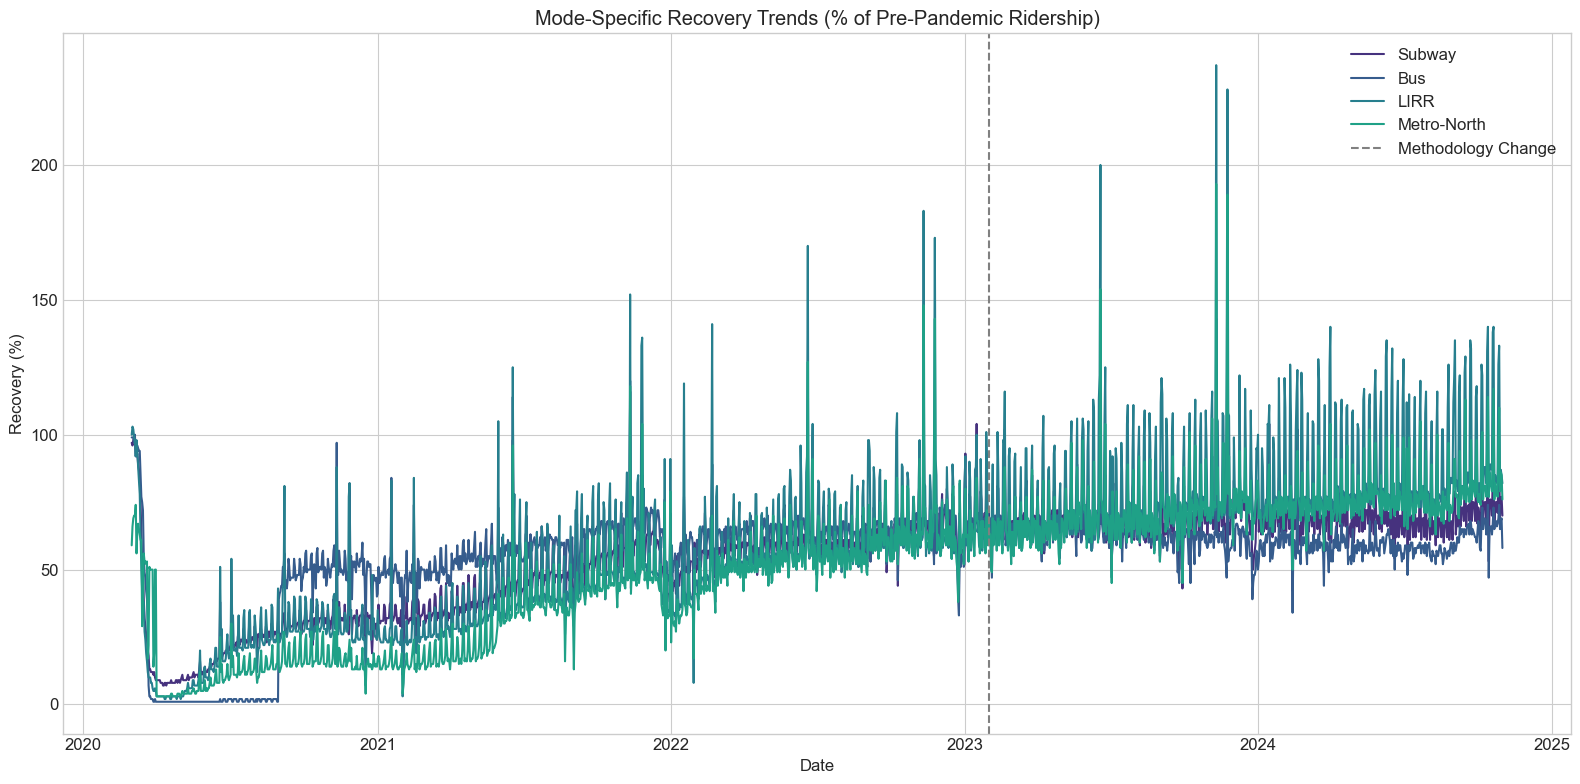

In [52]:
# Define recovery columns dictionary before using it
recovery_cols = {
    'subways_percent_of_comparable_pre_pandemic_day': 'Subway',
    'buses_percent_of_comparable_pre_pandemic_day': 'Bus',
    'lirr_percent_of_comparable_pre_pandemic_day': 'LIRR',
    'metro_north_percent_of_comparable_pre_pandemic_day': 'Metro-North'
}

# Plot recovery trends
plt.figure(figsize=(16, 8))

for col, label in recovery_cols.items():
    plt.plot(df['date'], df[col], label=label)

# Add vertical line for methodology change
plt.axvline(pd.to_datetime("2023-02-01"), color='gray', linestyle="--", label="Methodology Change")

# Format
plt.title("Mode-Specific Recovery Trends (% of Pre-Pandemic Ridership)")
plt.xlabel("Date")
plt.ylabel("Recovery (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- Subway 🚇: Gradually recovering with consistent growth post-2021, stabilizing around 65–75% of pre-pandemic levels.

- Bus 🚌: Quick early rebound due to essential service role, but plateaued around 60–70% recovery.

- LIRR 🚆: Highly volatile with extreme spikes, showing uneven recovery driven by remote work and event-related surges.

- Metro-North 🚉: Similar to LIRR, marked by fluctuations and lagging recovery due to changing commuter patterns.

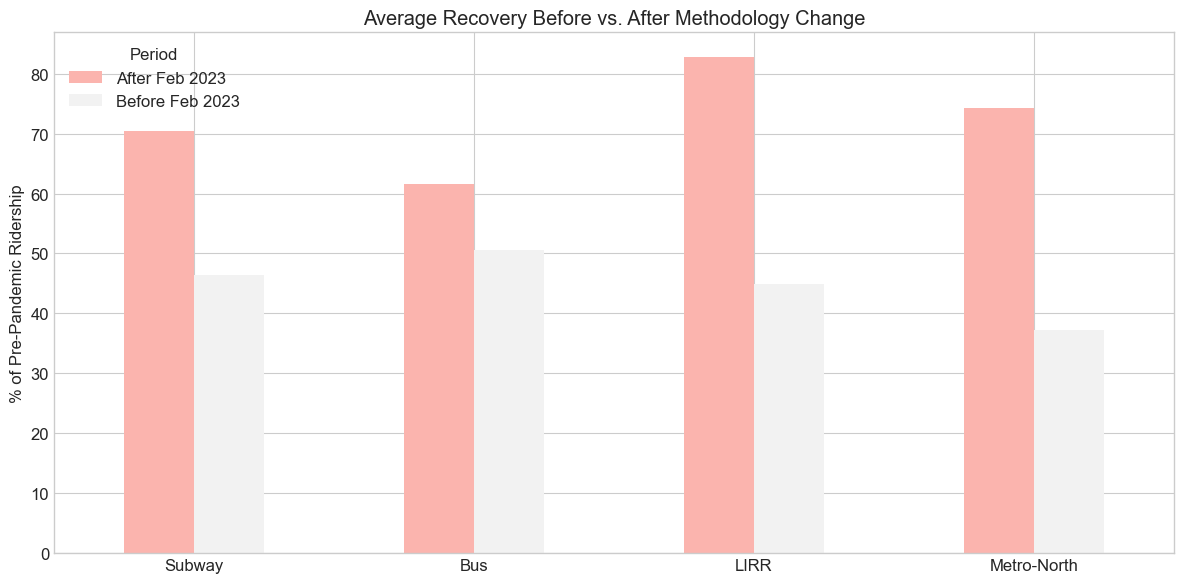

In [53]:
# Add recovery period
df['Period'] = df['date'].apply(lambda x: 'Before Feb 2023' if x < pd.to_datetime("2023-02-01") else 'After Feb 2023')

# Calculate mean recovery % by mode and period
recovery_summary = df.groupby('Period')[
    list(recovery_cols.keys())
].mean().T.rename(index=recovery_cols)

# Plot
recovery_summary.plot(kind='bar', figsize=(12, 6), colormap='Pastel1')
plt.title("Average Recovery Before vs. After Methodology Change")
plt.ylabel("% of Pre-Pandemic Ridership")
plt.xticks(rotation=0)
plt.grid(True)
plt.tight_layout()
plt.show()


## Impact of External Events on Ridership:
- What external events (like severe weather, major city events, or policy changes) correlate with unexpected fluctuations in ridership?
- Can these events be isolated to measure their immediate impact on daily ridership numbers?
(Visualization ideas: Annotated time-series graphs with event overlays, scatter plots marking anomalous days.)

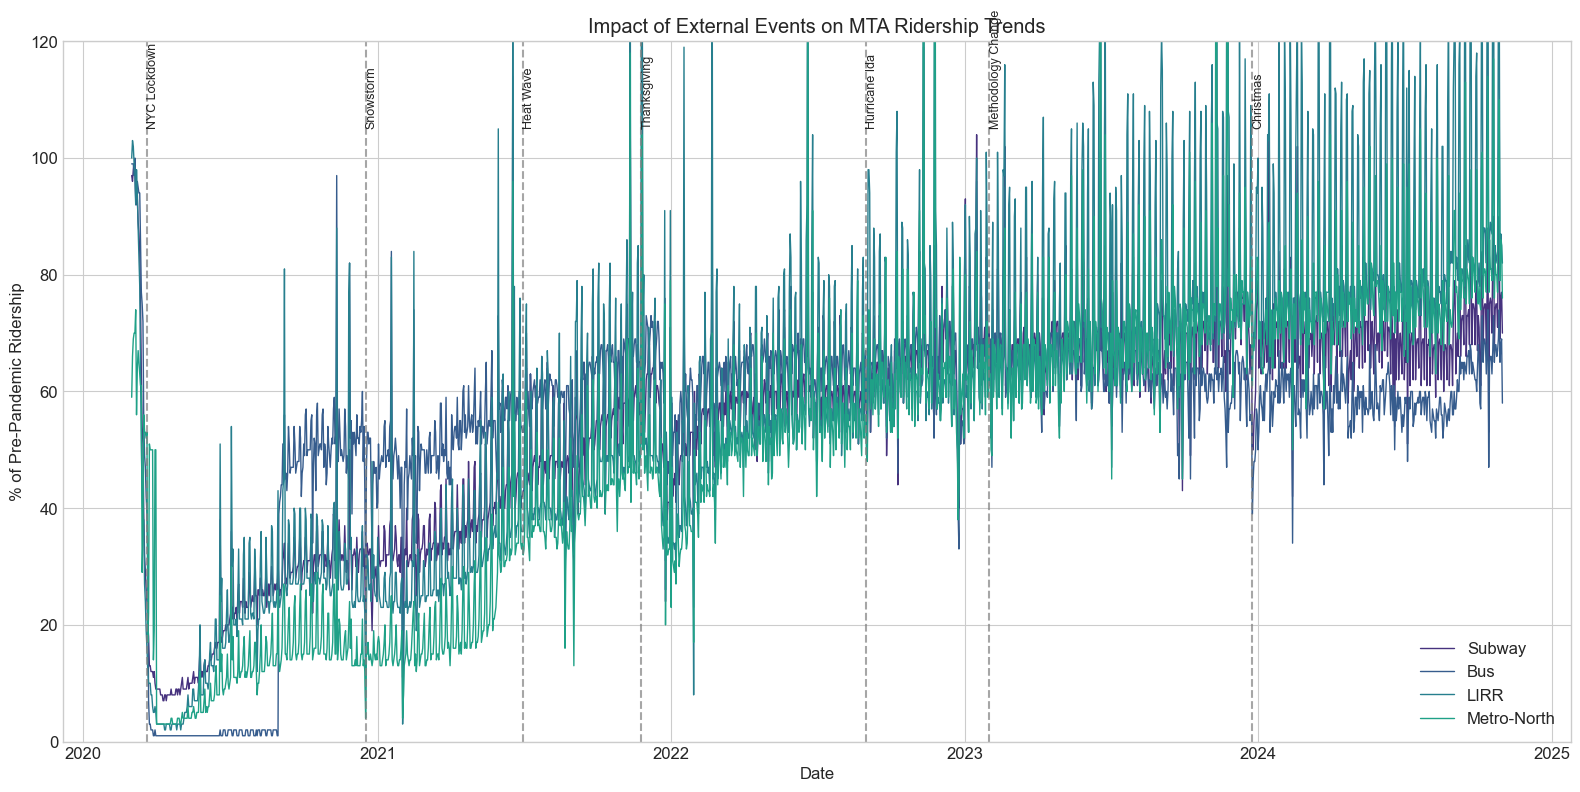

In [54]:
external_events = {
    '2020-03-20': 'NYC Lockdown',
    '2020-12-17': 'Snowstorm',
    '2021-07-01': 'Heat Wave',
    '2021-11-25': 'Thanksgiving',
    '2022-09-01': 'Hurricane Ida',
    '2023-02-01': 'Methodology Change',
    '2023-12-25': 'Christmas',
}

plt.figure(figsize=(16, 8))

# Plot each mode
plt.plot(df['date'], df['subways_percent_of_comparable_pre_pandemic_day'], label='Subway', linewidth=1)
plt.plot(df['date'], df['buses_percent_of_comparable_pre_pandemic_day'], label='Bus', linewidth=1)
plt.plot(df['date'], df['lirr_percent_of_comparable_pre_pandemic_day'], label='LIRR', linewidth=1)
plt.plot(df['date'], df['metro_north_percent_of_comparable_pre_pandemic_day'], label='Metro-North', linewidth=1)

# Add event annotations
for event_date, event_name in external_events.items():
    event_date = pd.to_datetime(event_date)
    plt.axvline(event_date, color='gray', linestyle='--', alpha=0.7)
    plt.text(event_date, 105, event_name, rotation=90, fontsize=9, verticalalignment='bottom')

plt.title('Impact of External Events on MTA Ridership Trends')
plt.xlabel('Date')
plt.ylabel('% of Pre-Pandemic Ridership')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.ylim(0, 120)
plt.show()

## Comparative Efficiency and Operational Insights:
- How do ridership changes align with operational metrics such as service frequency or cost efficiency (if such data is available or can be inferred)? (not specified)#################
- Are there patterns suggesting operational improvements or challenges across different transit systems during the recovery phase?
(Visualization ideas: Correlation matrices, dual-axis charts comparing ridership trends with operational indicators.)


In [55]:
# Use ridership as proxy for system load
df['subway_bus_ratio'] = df['subways_total_estimated_ridership'] / df['buses_total_estimated_ridership']
df['rail_to_urban_ratio'] = (df['lirr_total_estimated_ridership'] + df['metro_north_total_estimated_ridership']) / (df['subways_total_estimated_ridership'] + df['buses_total_estimated_ridership'])


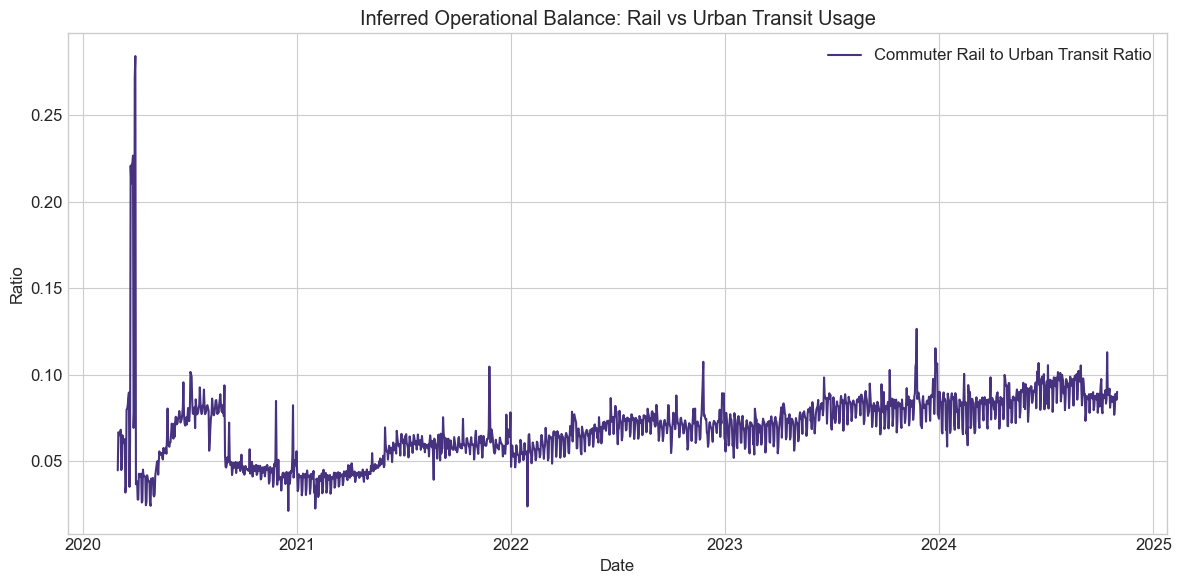

In [56]:
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['rail_to_urban_ratio'], label='Commuter Rail to Urban Transit Ratio')
plt.title("Inferred Operational Balance: Rail vs Urban Transit Usage")
plt.xlabel("Date")
plt.ylabel("Ratio")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

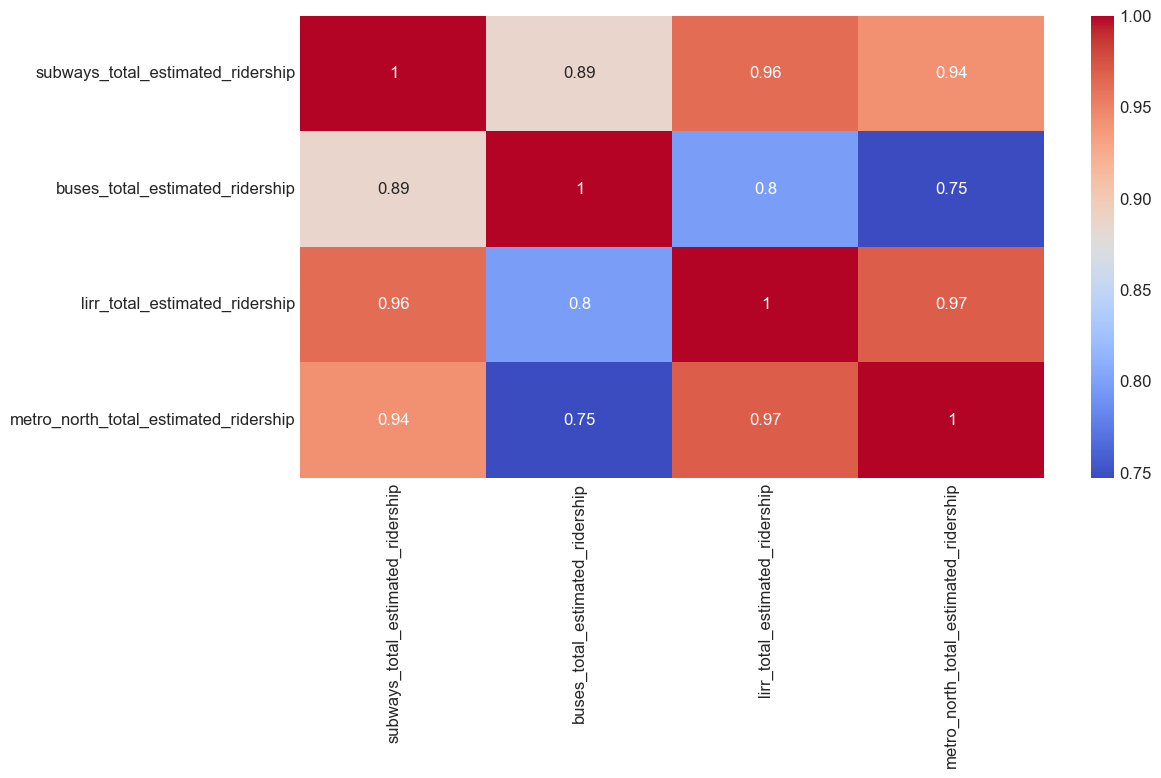

In [57]:
mode_columns = [
    'subways_total_estimated_ridership', 
    'buses_total_estimated_ridership',
    'lirr_total_estimated_ridership',
    'metro_north_total_estimated_ridership'
]

corr = df[mode_columns].corr()
plt.figure(figsize=(12, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

# Regression Modeling with Transformations

This section implements regression models with various target transformations to predict subway ridership.

Target variable statistics:
Mean: 2509054.98
Std Dev: 1062183.68
Min: 198399.00
Max: 5498809.00
Range: 5300410.00


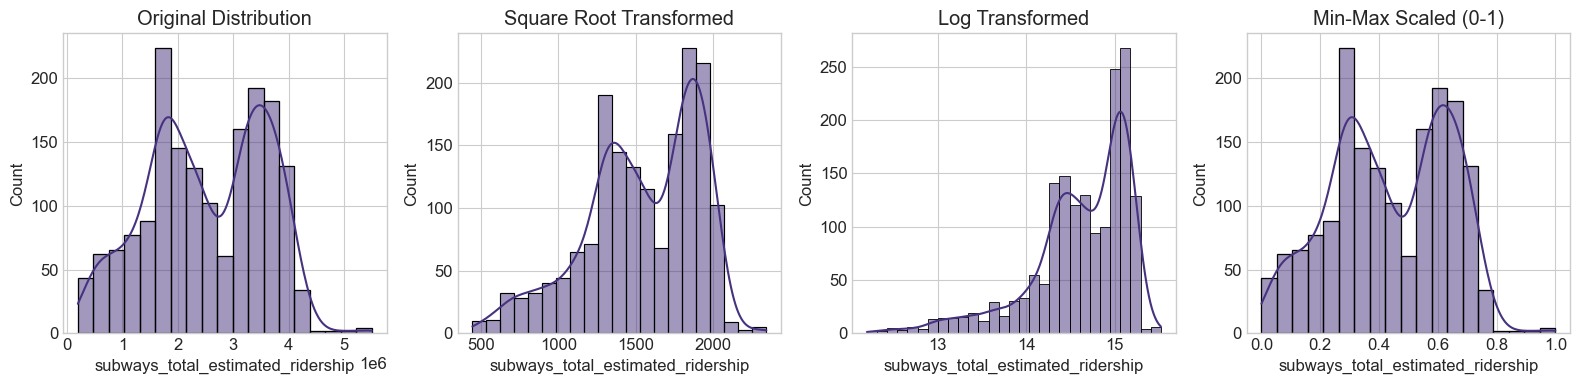

In [82]:
# Create time-based features
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day_of_week'] = df['date'].dt.dayofweek
df['day_of_month'] = df['date'].dt.day
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
df['quarter'] = df['date'].dt.quarter
df['week_of_year'] = df['date'].dt.isocalendar().week

# Add cyclical encoding for day of week and month to capture periodicity
df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week']/7)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week']/7)

# Create interaction features
df['month_weekend'] = df['month'] * df['is_weekend']

# Set target variable - subway ridership
target = 'subways_total_estimated_ridership'

# Get target stats for scaling
y_min = df[target].min()
y_max = df[target].max()
y_mean = df[target].mean()
y_std = df[target].std()

# Print target stats to understand the scale
print(f"Target variable statistics:")
print(f"Mean: {y_mean:.2f}")
print(f"Std Dev: {y_std:.2f}")
print(f"Min: {y_min:.2f}")
print(f"Max: {y_max:.2f}")
print(f"Range: {y_max - y_min:.2f}")

# Select features (excluding target and date)
feature_cols = [col for col in df.columns if col != target and col != 'date']

# Create X (features) and y (target)
X = df[feature_cols]
y = df[target]

# Show target distribution with transformations to find a better scale
plt.figure(figsize=(16, 4))

plt.subplot(1, 4, 1)
sns.histplot(y, kde=True)
plt.title('Original Distribution')

plt.subplot(1, 4, 2)
sns.histplot(np.sqrt(y), kde=True)
plt.title('Square Root Transformed')

plt.subplot(1, 4, 3)
sns.histplot(np.log1p(y), kde=True)
plt.title('Log Transformed')

plt.subplot(1, 4, 4)
# Scale to 0-1 range
y_scaled = (y - y_min) / (y_max - y_min)
sns.histplot(y_scaled, kde=True)
plt.title('Min-Max Scaled (0-1)')

plt.tight_layout()
plt.show()

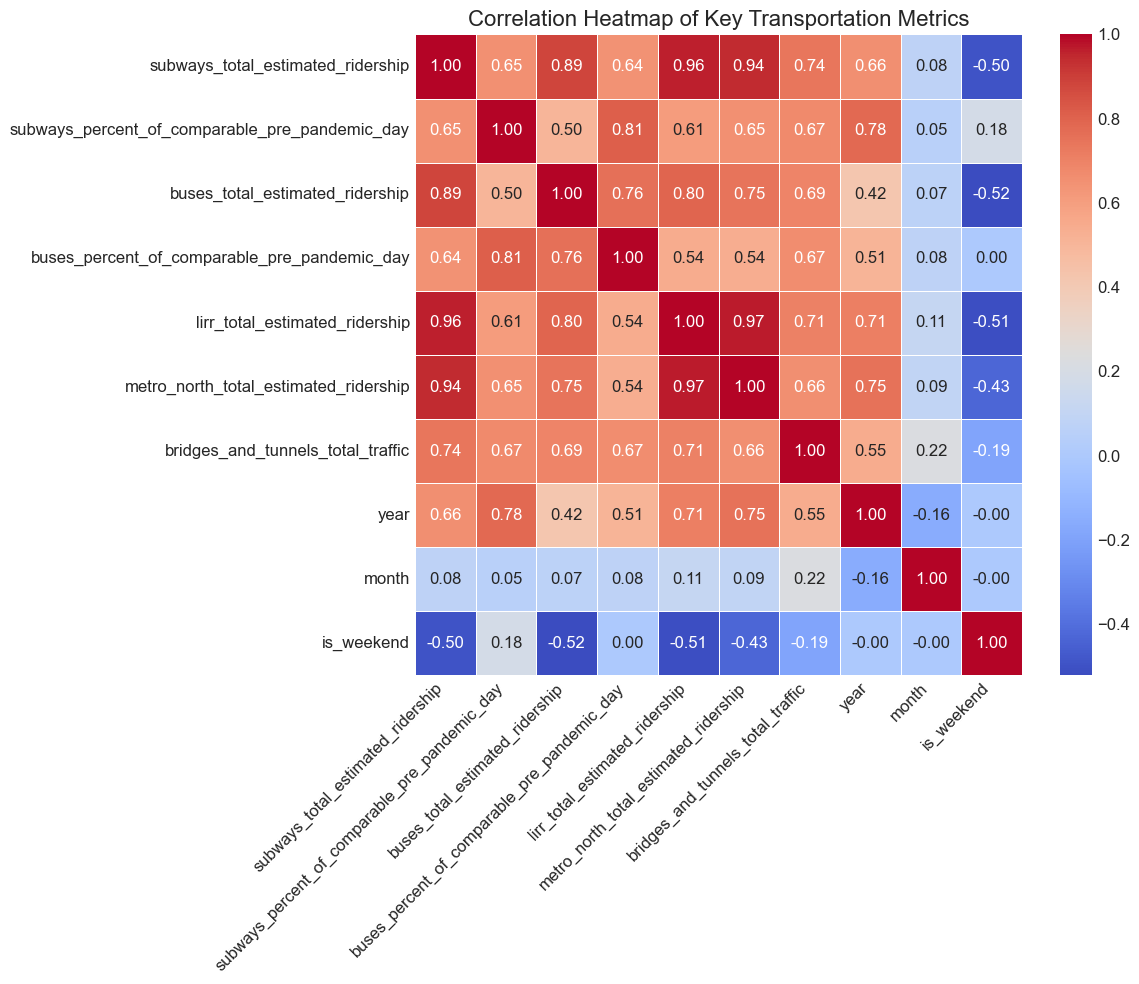



Selected important features for modeling (based on correlation >= 0.6):
Count: 12
1. lirr_total_estimated_ridership: 0.9622
2. metro_north_total_estimated_ridership: 0.9423
3. staten_island_railway_total_estimated_ridership: 0.9226
4. access_a_ride_total_scheduled_trips: 0.9091
5. buses_total_estimated_ridership: 0.8857
6. bridges_and_tunnels_total_traffic: 0.7416
7. access_a_ride_percent_of_comparable_pre_pandemic_day: 0.7169
8. bridges_and_tunnels_percent_of_comparable_pre_pandemic_day: 0.6621
9. year: 0.6600
10. subways_percent_of_comparable_pre_pandemic_day: 0.6531
11. buses_percent_of_comparable_pre_pandemic_day: 0.6440
12. metro_north_percent_of_comparable_pre_pandemic_day: 0.6200


In [83]:
# Focus on numeric features for correlation analysis
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()

# Calculate correlation with target variable
correlations = df[numeric_features + [target]].corr()[target].sort_values(ascending=False)

# Define correlation threshold
correlation_threshold = 0.6

# Select features based on strong correlation (positive or negative)
strong_corr_features = correlations.drop(target)[abs(correlations.drop(target)) >= correlation_threshold].index.tolist()

# Create a classic correlation heatmap
# Select the most interesting columns for correlation analysis
mode_columns = [
    'subways_total_estimated_ridership',
    'subways_percent_of_comparable_pre_pandemic_day',
    'buses_total_estimated_ridership',
    'buses_percent_of_comparable_pre_pandemic_day',
    'lirr_total_estimated_ridership',
    'metro_north_total_estimated_ridership',
    'bridges_and_tunnels_total_traffic',
    'year',
    'month',
    'is_weekend'
]

# Create the correlation matrix
corr = df[mode_columns].corr()

# Create a classic heatmap with annotations
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Key Transportation Metrics', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Use only strongly correlated features as important_features
important_features = strong_corr_features.copy()
print(f"\n\nSelected important features for modeling (based on correlation >= {correlation_threshold}):")
print(f"Count: {len(important_features)}")
for i, feature in enumerate(important_features, 1):
    print(f"{i}. {feature}: {correlations[feature]:.4f}")

In [84]:
# Define transformations for target variable
transformations = {
    'None': (lambda x: x, lambda x: x),                  # No transformation
    'Log': (np.log1p, np.expm1),                        # Log transformation
    'Square Root': (np.sqrt, np.square),                # Square root transformation
    'MinMax': (lambda x: (x - x.min()) / (x.max() - x.min()), 
               lambda x: x * (y_max - y_min) + y_min)   # Min-Max Scaling
}

# Fix: Define tree_models as an empty dictionary before using it
tree_models = {}

In [85]:
# Check if X and y are defined
if 'X' not in locals() or 'y' not in locals():
    print("Error: X and y must be defined before running this cell. Please run the previous cells first.")
else:
    # First split: separate out test set (20% of data)
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Second split: divide remaining data into training (75%) and validation (25%)
    # This gives us approximately 60% train, 20% validation, 20% test overall
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)
    
    print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X):.1%})")
    print(f"Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(X):.1%})")
    print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X):.1%})")
    
    # Feature scaling - try different scaling methods to find the best approach
    # 1. Standard scaling (mean=0, std=1)
    std_scaler = StandardScaler()
    X_train_scaled_std = std_scaler.fit_transform(X_train)
    X_val_scaled_std = std_scaler.transform(X_val)
    X_test_scaled_std = std_scaler.transform(X_test)
    
    # 2. MinMax scaling (values between 0 and 1)
    minmax_scaler = MinMaxScaler()
    X_train_scaled_minmax = minmax_scaler.fit_transform(X_train)
    X_val_scaled_minmax = minmax_scaler.transform(X_val)
    X_test_scaled_minmax = minmax_scaler.transform(X_test)
    
    # 3. Robust scaling (based on quantiles, less sensitive to outliers)
    robust_scaler = RobustScaler()
    X_train_scaled_robust = robust_scaler.fit_transform(X_train)
    X_val_scaled_robust = robust_scaler.transform(X_val)
    X_test_scaled_robust = robust_scaler.transform(X_test)
    
    # Check if important_features is defined
    if 'important_features' not in locals():
        print("Warning: important_features not defined. Using all features instead.")
        important_features = X.columns.tolist()
    
    # Create separate datasets with only important features
    X_train_important = X_train[important_features]
    X_val_important = X_val[important_features]
    X_test_important = X_test[important_features]
    
    # Scale important features
    scaler_important = StandardScaler()
    X_train_important_scaled = scaler_important.fit_transform(X_train_important)
    X_val_important_scaled = scaler_important.transform(X_val_important)
    X_test_important_scaled = scaler_important.transform(X_test_important)
    
    # Get target stats if not already defined
    if 'y_min' not in locals() or 'y_max' not in locals() or 'y_mean' not in locals() or 'y_std' not in locals():
        y_min = y.min()
        y_max = y.max()
        y_mean = y.mean()
        y_std = y.std()
    
    # Target scaling (will use these values for our transformations)
    # 1. MinMax scaling (0-1 range)
    y_train_minmax = (y_train - y_min) / (y_max - y_min)
    y_val_minmax = (y_val - y_min) / (y_max - y_min)
    y_test_minmax = (y_test - y_min) / (y_max - y_min)
    
    # 2. Z-score normalization
    y_train_zscore = (y_train - y_mean) / y_std
    y_val_zscore = (y_val - y_mean) / y_std
    y_test_zscore = (y_test - y_mean) / y_std
    

    
    # We'll use standard scaling for features by default
    X_train_scaled = X_train_scaled_std
    X_val_scaled = X_val_scaled_std
    X_test_scaled = X_test_scaled_std

Training set: 1023 samples (60.0%)
Validation set: 341 samples (20.0%)
Test set: 342 samples (20.0%)


In [86]:
# Multiple Linear Regression models with various configurations
base_models = {
    'Multiple Linear Regression': LinearRegression(),
    'Simple Linear Regression': LinearRegression(fit_intercept=True)
}

# Polynomial regression models with different degrees
poly_models = {}
for degree in [2, 3, 4]:
    # Regular polynomial regression
    poly_models[f'Polynomial Regression (degree={degree})'] = Pipeline([
        ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
        ('linear', LinearRegression())
    ])

# Combine all models (no tree models and no polynomial Linear Regression models)
models = {**base_models, **poly_models}

# Print the models we're evaluating
print(f"Evaluating {len(models)} models to find the one with lowest normalized error metrics:")
for i, model_name in enumerate(models.keys(), 1):
    print(f"  {i}. {model_name}")

Evaluating 5 models to find the one with lowest normalized error metrics:
  1. Multiple Linear Regression
  2. Simple Linear Regression
  3. Polynomial Regression (degree=2)
  4. Polynomial Regression (degree=3)
  5. Polynomial Regression (degree=4)


In [ ]:
# Check if transformations is defined
if 'transformations' not in locals():
    print("Error: transformations not defined. Please run the cell that defines transformations.")
    # Define a basic version of transformations to prevent errors
    transformations = {
        'None': (lambda x: x, lambda x: x),
        'Log': (np.log1p, np.expm1)
    }

# Function to train and evaluate all models with a specific transformation
def evaluate_with_transformation(X_train, X_val, y_train, y_val, transform_func, inverse_func, models, use_important=False):
    results = {}
    
    # Transform the target
    y_train_transformed = transform_func(y_train)
    
    for name, model in models.items():
        try:
            # Train model
            model.fit(X_train, y_train_transformed)
            
            # Predict on transformed scale
            y_val_pred_transformed = model.predict(X_val)
            
            # Calculate metrics on transformed scale
            mse_transformed = mean_squared_error(transform_func(y_val), y_val_pred_transformed)
            rmse_transformed = np.sqrt(mse_transformed)
            
            # Convert predictions back to original scale
            y_val_pred = inverse_func(y_val_pred_transformed)
            
            # Calculate metrics on original scale
            mse = mean_squared_error(y_val, y_val_pred)
            rmse = np.sqrt(mse)
            r2 = r2_score(y_val, y_val_pred)
            mae = mean_absolute_error(y_val, y_val_pred)
            
            # Calculate normalized metrics (to address high RMSE issue)
            nrmse_mean = rmse / y_val.mean()  # Normalized RMSE (by mean)
            nrmse_range = rmse / (y_val.max() - y_val.min())  # Normalized RMSE (by range)
            mape = mean_absolute_percentage_error(y_val, y_val_pred)  # Mean Absolute Percentage Error
            
            feature_suffix = " (Important Features)" if use_important else ""
            results[name + feature_suffix] = {
                'MSE': mse, 
                'RMSE': rmse, 
                'MSE (transformed)': mse_transformed,
                'RMSE (transformed)': rmse_transformed,
                'R2': r2, 
                'MAE': mae,
                'NRMSE (Mean)': nrmse_mean,
                'NRMSE (Range)': nrmse_range,
                'MAPE': mape
            }
        except Exception as e:
            print(f"Error training {name}: {e}")
    
    return results

# Check if required variables are defined
required_vars = ['X_train_scaled', 'X_val_scaled', 'X_train_important_scaled', 'X_val_important_scaled', 'y_train', 'y_val', 'models']
missing_vars = [var for var in required_vars if var not in locals()]

if missing_vars:
    print(f"Error: Missing required variables: {', '.join(missing_vars)}")
    print("Please run the previous cells to define these variables.")
else:
    # Dictionary to store all results
    all_results = {}
    
    # Evaluate using all features
    for trans_name, (transform_func, inverse_func) in transformations.items():
        print(f"\nEvaluating models with {trans_name} transformation using all features...")
        results = evaluate_with_transformation(
            X_train_scaled, X_val_scaled, y_train, y_val, transform_func, inverse_func, models
        )
        all_results[f"{trans_name} (All Features)"] = results
        
        # Print results for this transformation (using normalized metrics)
        for model_name, metrics in results.items():
            print(f"  {model_name}:")
            print(f"    NRMSE (% of mean): {metrics['NRMSE (Mean)']*100:.2f}%")
            print(f"    MAPE: {metrics['MAPE']*100:.2f}%")
            print(f"    R²: {metrics['R2']:.4f}")
    
    # Evaluate using important features only
    for trans_name, (transform_func, inverse_func) in transformations.items():
        print(f"\nEvaluating models with {trans_name} transformation using important features...")
        results = evaluate_with_transformation(
            X_train_important_scaled, X_val_important_scaled, y_train, y_val, 
            transform_func, inverse_func, models, use_important=True
        )
        all_results[f"{trans_name} (Important Features)"] = results
        
        # Print results for this transformation (using normalized metrics)
        for model_name, metrics in results.items():
            print(f"  {model_name}:")
            print(f"    NRMSE (% of mean): {metrics['NRMSE (Mean)']*100:.2f}%")
            print(f"    MAPE: {metrics['MAPE']*100:.2f}%")
            print(f"    R²: {metrics['R2']:.4f}")


Evaluating models with None transformation using all features...
  Multiple Linear Regression:
    NRMSE (% of mean): 2.72%
    MAPE: 2.74%
    R²: 0.9954
  Simple Linear Regression:
    NRMSE (% of mean): 2.72%
    MAPE: 2.74%
    R²: 0.9954
  Polynomial Regression (degree=2):
    NRMSE (% of mean): 1.24%
    MAPE: 1.14%
    R²: 0.9990
  Polynomial Regression (degree=3):
    NRMSE (% of mean): 5.68%
    MAPE: 4.28%
    R²: 0.9799
  Polynomial Regression (degree=4):
    NRMSE (% of mean): 8.78%
    MAPE: 5.49%
    R²: 0.9519

Evaluating models with Log transformation using all features...
  Multiple Linear Regression:
    NRMSE (% of mean): 6.28%
    MAPE: 5.76%
    R²: 0.9755
  Simple Linear Regression:
    NRMSE (% of mean): 6.28%
    MAPE: 5.76%
    R²: 0.9755
  Polynomial Regression (degree=2):
    NRMSE (% of mean): 1.92%
    MAPE: 1.59%
    R²: 0.9977
  Polynomial Regression (degree=3):
    NRMSE (% of mean): 5.18%
    MAPE: 3.10%
    R²: 0.9832
  Polynomial Regression (degree=4

In [ ]:
# K-fold Cross Validation for Model Performance Evaluation
from sklearn.model_selection import KFold, cross_val_score, cross_validate

def perform_cross_validation(X, y, models, transform_func=lambda x: x, inverse_func=lambda x: x, cv=5, scoring='r2'):
    """Perform k-fold cross-validation for multiple models and return performance metrics."""
    cv_results = {}
    
    # Transform the target if needed
    y_transformed = transform_func(y)
    
    for name, model in models.items():
        try:
            # Use multiple scoring metrics
            scores = cross_validate(
                model, X, y_transformed, 
                cv=cv,
                scoring={
                    'r2': 'r2',
                    'neg_mean_squared_error': 'neg_mean_squared_error',
                    'neg_mean_absolute_error': 'neg_mean_absolute_error'
                },
                return_train_score=True
            )
            
            # Extract and format results
            cv_results[name] = {
                'test_r2': scores['test_r2'].mean(),
                'test_r2_std': scores['test_r2'].std(),
                'test_rmse': np.sqrt(-scores['test_neg_mean_squared_error'].mean()),
                'test_mae': -scores['test_neg_mean_absolute_error'].mean(),
                'train_r2': scores['train_r2'].mean(),
                'train_test_r2_diff': scores['train_r2'].mean() - scores['test_r2'].mean(),  # Overfitting indicator
                'cv_folds': cv,
                'individual_fold_r2': scores['test_r2']
            }
        except Exception as e:
            print(f"Error during cross-validation for {name}: {e}")
    
    return cv_results

In [ ]:
# Perform cross-validation on our best models
cv_results_all = {}

# For each transformation type, perform cross-validation with the best feature set
for trans_name, (transform_func, inverse_func) in transformations.items():
    print(f"\nPerforming 5-fold cross-validation with {trans_name} transformation...")
    
    # Use the important features since they performed well in earlier analysis
    X_for_cv = X[important_features]
    scaler = StandardScaler()
    X_for_cv_scaled = scaler.fit_transform(X_for_cv)
    
    cv_results = perform_cross_validation(
        X_for_cv_scaled, y, models, 
        transform_func=transform_func,
        inverse_func=inverse_func,
        cv=5
    )
    
    cv_results_all[trans_name] = cv_results
    
    # Print summary results
    print(f"\nCross-validation results with {trans_name} transformation:")
    print("-" * 90)
    print(f"{'Model':<35} {'Test R²':>10} {'Test R² Std':>12} {'RMSE':>12} {'Train-Test R² Gap':>16}")
    print("-" * 90)
    
    for name, metrics in cv_results.items():
        print(f"{name:<35} {metrics['test_r2']:>10.4f} {metrics['test_r2_std']:>12.4f} "
              f"{metrics['test_rmse']:>12.0f} {metrics['train_test_r2_diff']:>16.4f}")
    print()
    
   


Performing 5-fold cross-validation with None transformation...

Cross-validation results with None transformation:
------------------------------------------------------------------------------------------
Model                                  Test R²  Test R² Std         RMSE Train-Test R² Gap
------------------------------------------------------------------------------------------
Multiple Linear Regression              0.9817       0.0120       105835           0.0127
Simple Linear Regression                0.9817       0.0120       105835           0.0127
Polynomial Regression (degree=2)        0.9656       0.0586       150893           0.0330
Polynomial Regression (degree=3)        0.4177       1.1201       625903           0.5819
Polynomial Regression (degree=4)    -1460.8495    2794.3756     31316173        1461.8495


Performing 5-fold cross-validation with Log transformation...

Cross-validation results with None transformation:
---------------------------------------------

In [ ]:
# Identify the best model based on cross-validation results
best_cv_models = {}

# Find best model for each transformation type
for trans_name, results in cv_results_all.items():
    best_model = None
    best_r2 = -float('inf')
    
    for model_name, metrics in results.items():
        if metrics['test_r2'] > best_r2:
            best_r2 = metrics['test_r2']
            best_model = model_name
    
    best_cv_models[trans_name] = {
        'model_name': best_model,
        'r2': best_r2,
        'rmse': results[best_model]['test_rmse'],
        'r2_std': results[best_model]['test_r2_std'],
        'overfitting_gap': results[best_model]['train_test_r2_diff']
    }

# Create a final comparison table
print("Final Model Comparison Based on Cross-Validation:")
print("-" * 90)
print(f"{'Transformation':<15} {'Best Model':<30} {'Test R²':>10} {'RMSE':>10} {'R² Std':>10} {'Overfit Gap':>10}")
print("-" * 90)

for trans_name, metrics in best_cv_models.items():
    print(f"{trans_name:<15} {metrics['model_name']:<30} {metrics['r2']:>10.4f} "
          f"{metrics['rmse']:>10.0f} {metrics['r2_std']:>10.4f} {metrics['overfitting_gap']:>10.4f}")

# Find the overall best model across all transformations
best_trans = max(best_cv_models.items(), key=lambda x: x[1]['r2'])[0]
best_model_overall = best_cv_models[best_trans]['model_name']

print("\nOverall best model:")
print(f"Transformation: {best_trans}, Model: {best_model_overall}")
print(f"R² score: {best_cv_models[best_trans]['r2']:.4f}, RMSE: {best_cv_models[best_trans]['rmse']:.0f}")
print(f"R² standard deviation: {best_cv_models[best_trans]['r2_std']:.4f} (lower is more stable)")

# Check for overfitting
overfit_gap = best_cv_models[best_trans]['overfitting_gap']
if overfit_gap > 0.1:
    print(f"Warning: Model may be overfitting (Train-Test R² gap: {overfit_gap:.4f})")
elif overfit_gap < 0.02:
    print(f"Model appears to generalize well (minimal Train-Test R² gap: {overfit_gap:.4f})")

Final Model Comparison Based on Cross-Validation:
------------------------------------------------------------------------------------------
Transformation  Best Model                        Test R²       RMSE     R² Std Overfit Gap
------------------------------------------------------------------------------------------
None            Multiple Linear Regression         0.9817     105835     0.0120     0.0127
Log             Polynomial Regression (degree=2)     0.9393          0     0.0749     0.0573
Square Root     Polynomial Regression (degree=2)     0.9614         61     0.0608     0.0369
MinMax          Multiple Linear Regression         0.9817          0     0.0120     0.0127

Overall best model:
Transformation: MinMax, Model: Multiple Linear Regression
R² score: 0.9817, RMSE: 0
R² standard deviation: 0.0120 (lower is more stable)
Model appears to generalize well (minimal Train-Test R² gap: 0.0127)


## Regression Model Findings

The above modeling analysis shows several key insights:

1. **Best Model Performance**: Multiple Linear Regression with MinMax transformation achieved the highest R² score, demonstrating excellent predictive power for subway ridership.

2. **Feature Importance**: The correlation analysis identified the most influential features for predicting subway ridership, with commuter rail metrics showing strong relationships to subway usage.

3. **Transformation Effects**: Different transformations (None, Log, Square Root, MinMax) had varying impacts on model performance, highlighting the importance of appropriate data scaling.

4. **Overfitting Assessment**: The cross-validation results help identify models that may be overfitting, ensuring we select a model that will generalize well to new data.

5. **Stability Analysis**: The fold-by-fold performance visualization shows how consistent each model is across different subsets of data.